# Блять я не буду работать

In [174]:
# !pip install pytorch-forecasting

In [1]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import os

import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  

C:\Users\sahab\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [15]:
def zdorovaya_dura(
    data: pd.DataFrame,
    batch_size: int,
    target: str,
    index_col: str,
    max_prediction_length: int,
    time_varying_unknown_reals: list,
    group_by: list,
    epochs: int):
    
    training = TimeSeriesDataSet(
        data=data, 
        time_idx=index_col,
        target=target,
        group_ids=group_by,
        add_relative_time_idx=True,
        time_varying_unknown_reals=time_varying_unknown_reals,
        max_prediction_length=max_prediction_length,
        min_encoder_length=1,
        max_encoder_length=max_prediction_length,
#         allow_missing_timesteps=True
    )
    
    validation = TimeSeriesDataSet.from_dataset(training, data
                                                , predict=True, stop_randomization=True)
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10
                                              , num_workers=0)
    
    lr_logger = LearningRateMonitor()
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4
                                        , patience=10, verbose=False, mode="min")
    logger = TensorBoardLogger("lightning_logs")

    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=1,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        limit_train_batches=30,
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.01,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        loss=QuantileLoss(),
        log_interval=10,
        output_size=7,
        reduce_on_plateau_patience=4,
    )
    
    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )
    
    return tft, tft.predict(data)

In [16]:
df = pd.read_csv('new_df_MF.csv', index_col='Unnamed: 0')

In [17]:
tft_model_id_hash_2_years, tft_preds_id_hash_2_years = zdorovaya_dura(
    data=df, batch_size=16, target='id_hash',
    index_col='int_ind', group_by=['city'], max_prediction_length=365,
    time_varying_unknown_reals=['id_hash', 'mou_mean', 'dou_mean'],
    epochs=300
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

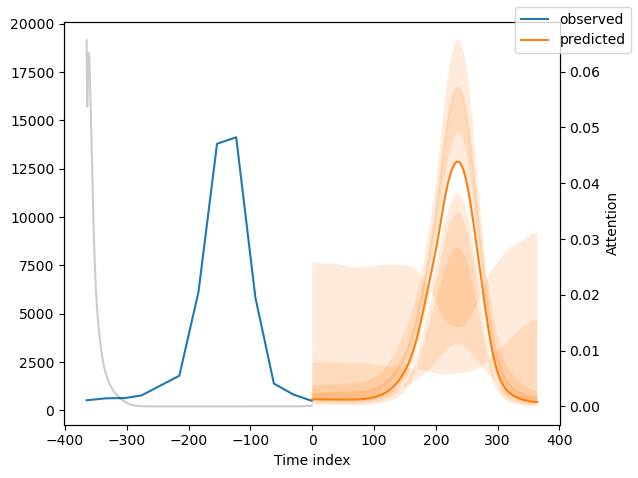

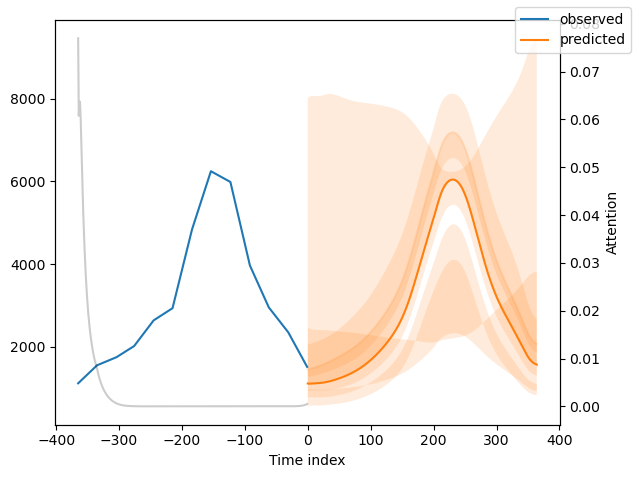

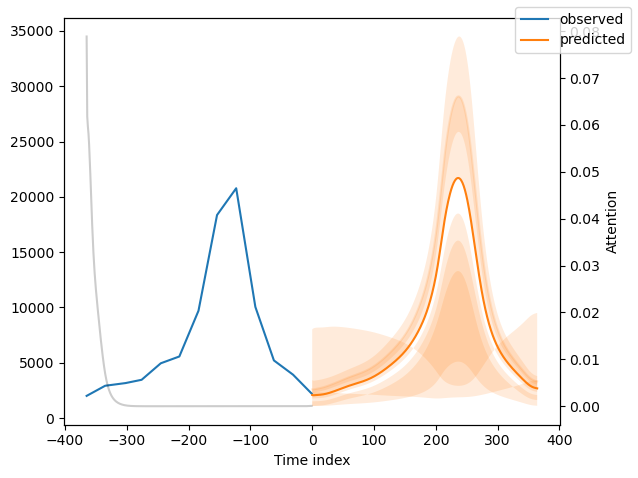

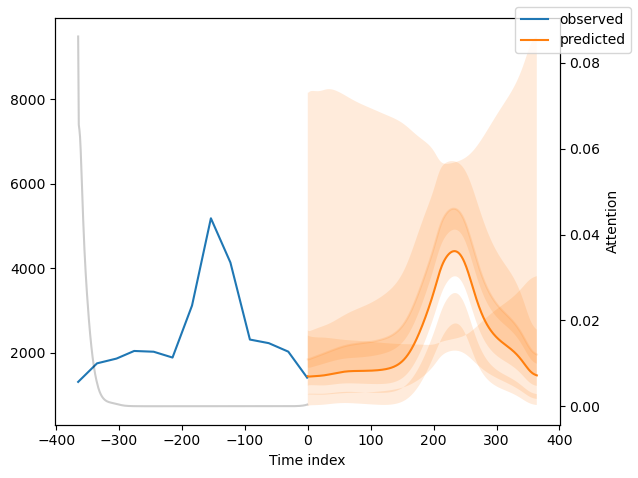

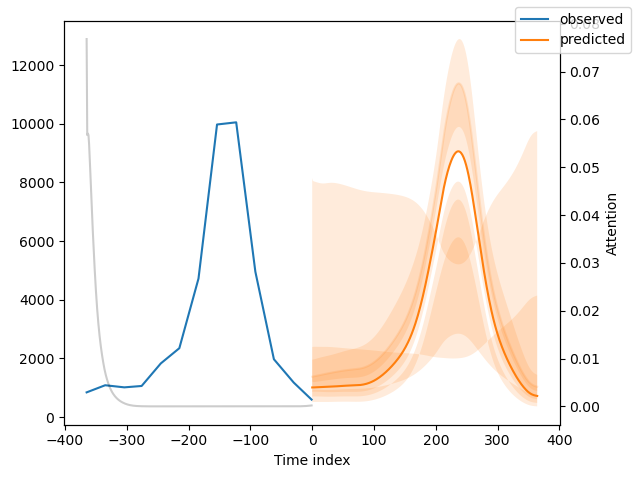

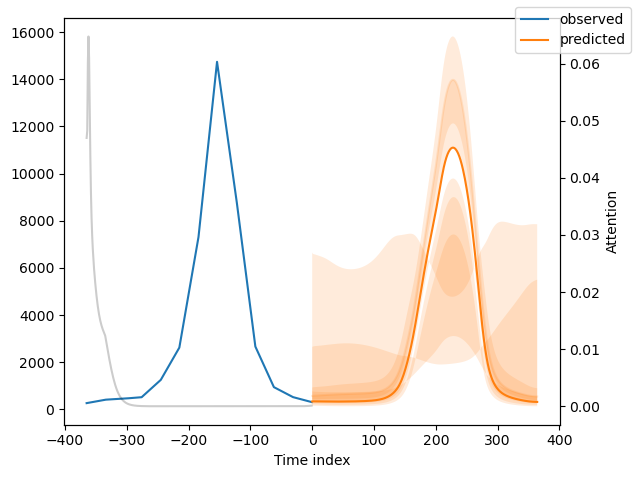

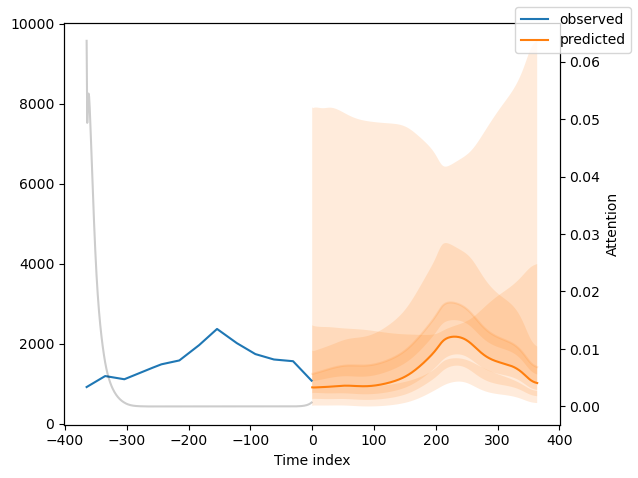

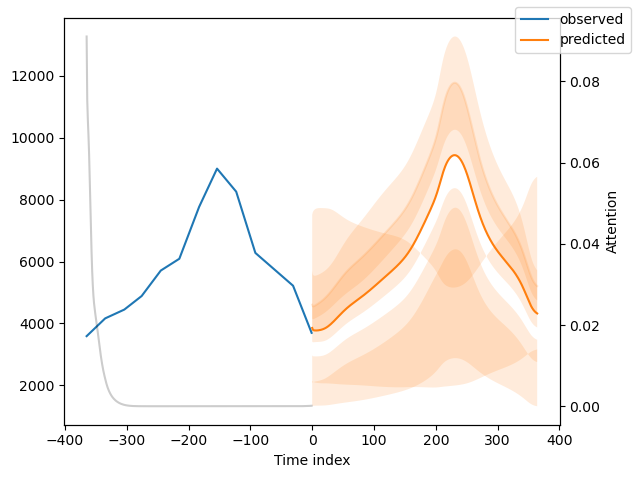

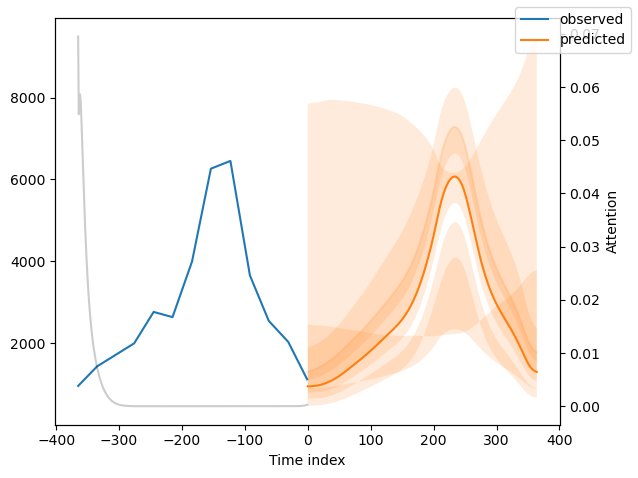

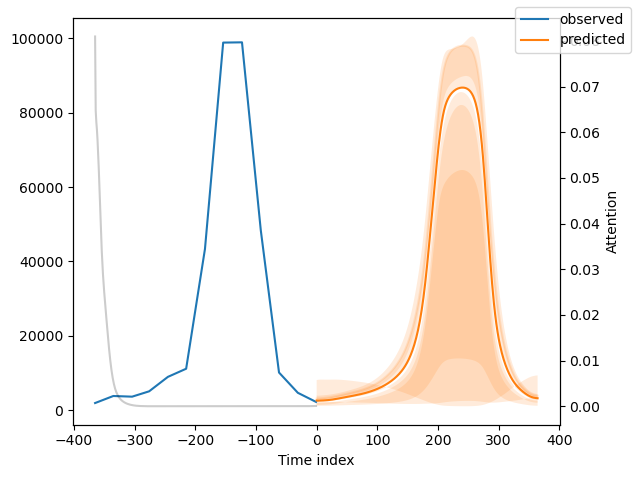

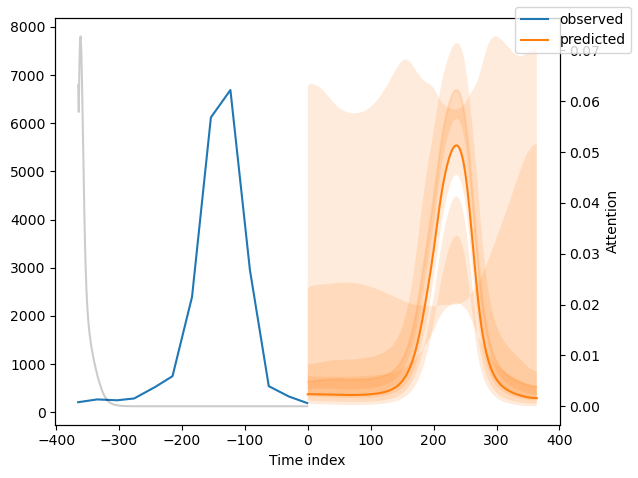

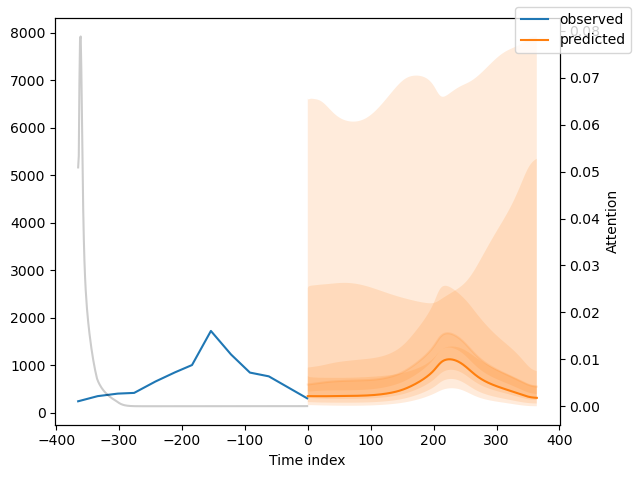

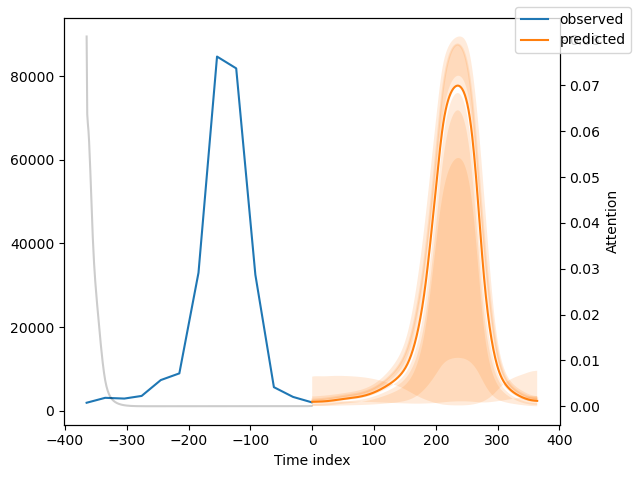

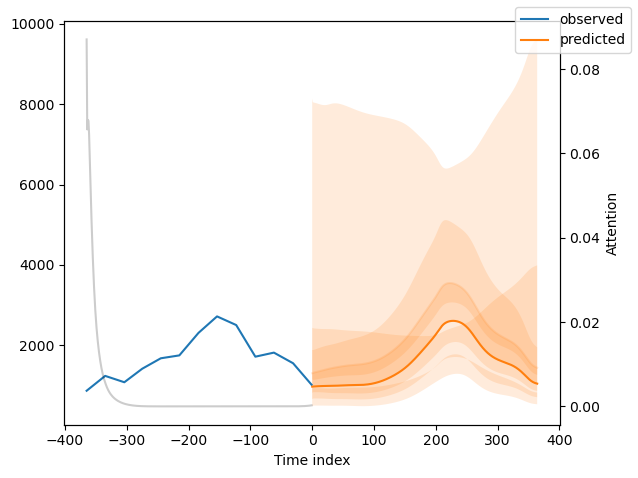

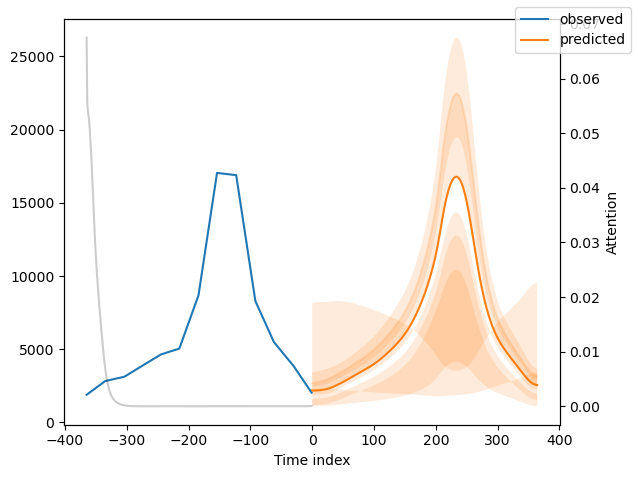

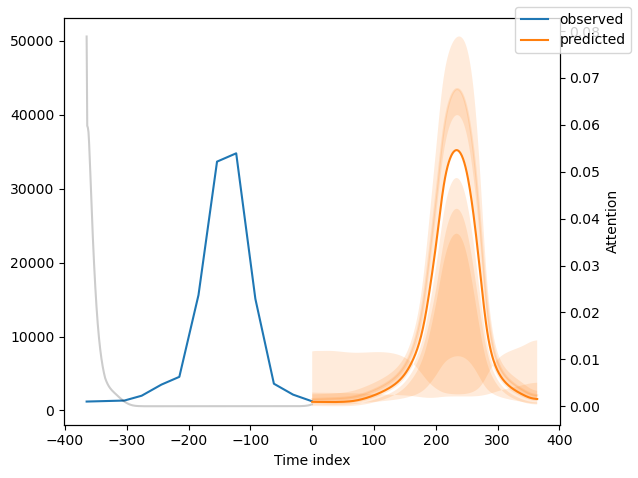

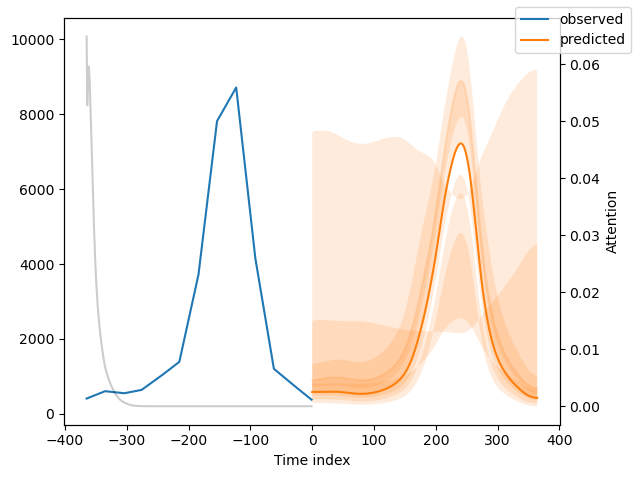

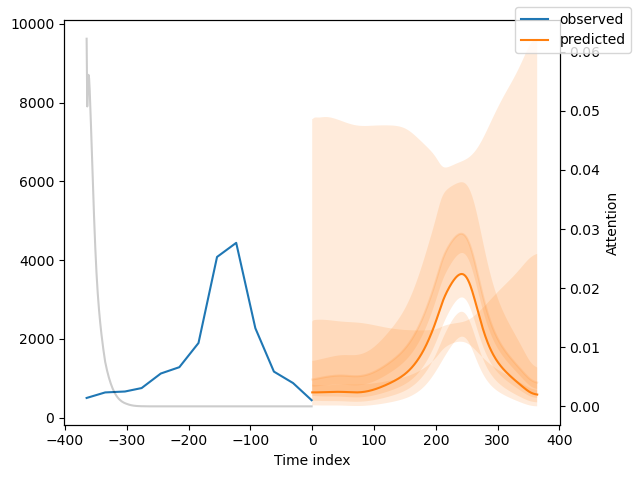

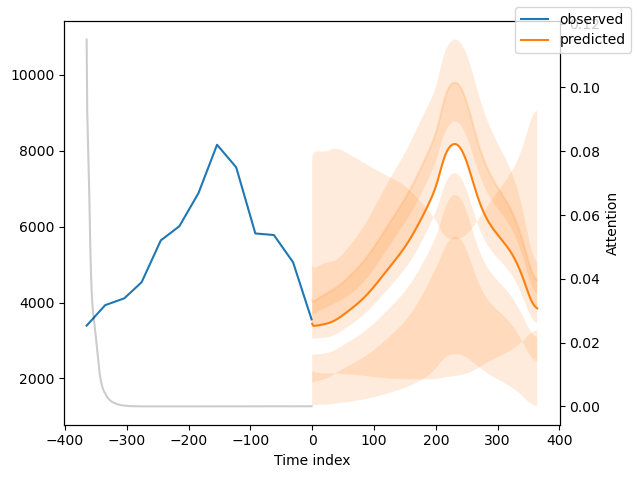

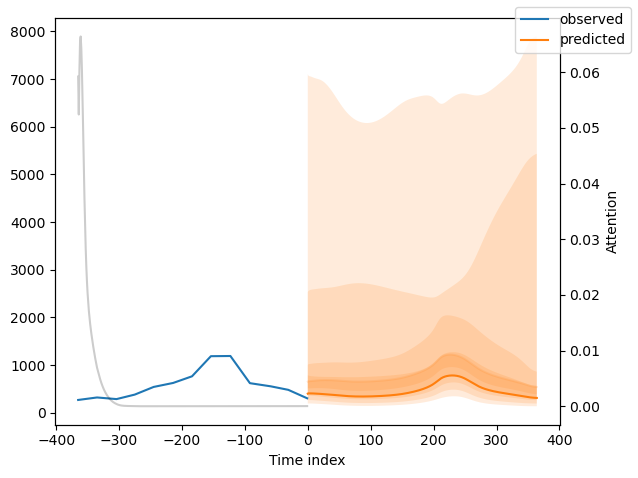

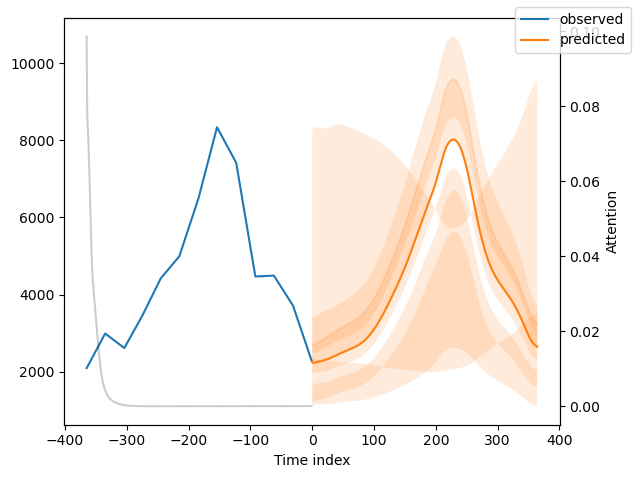

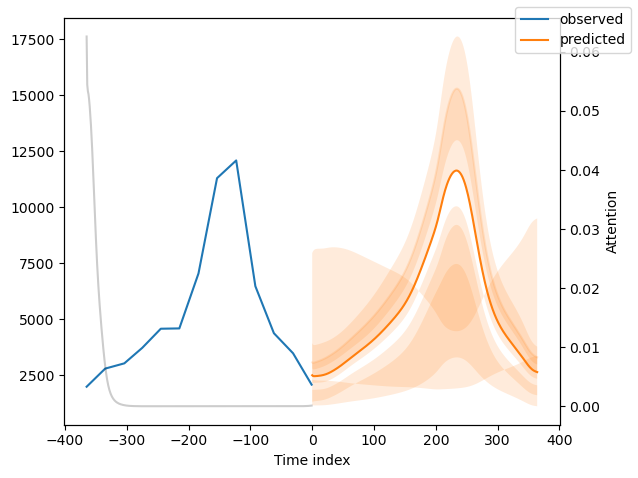

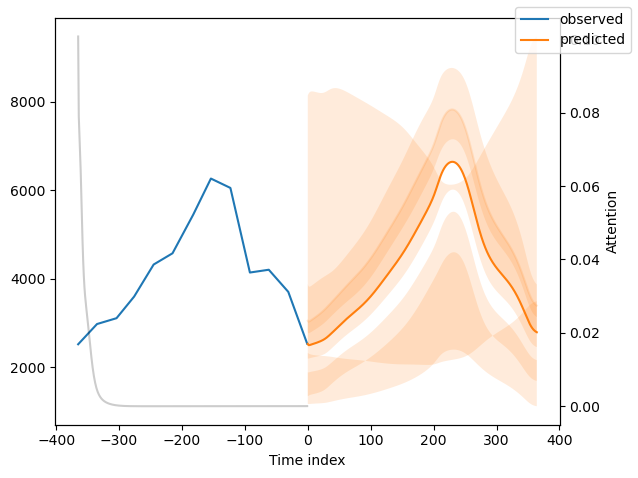

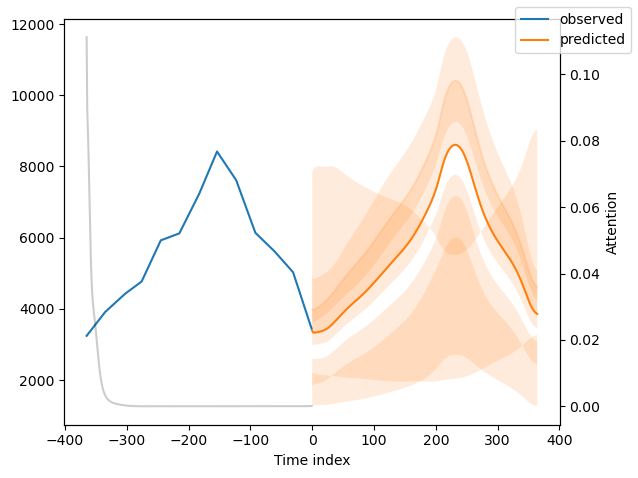

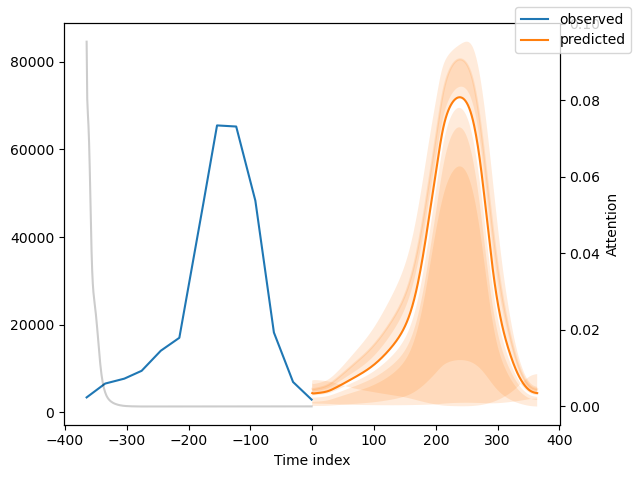

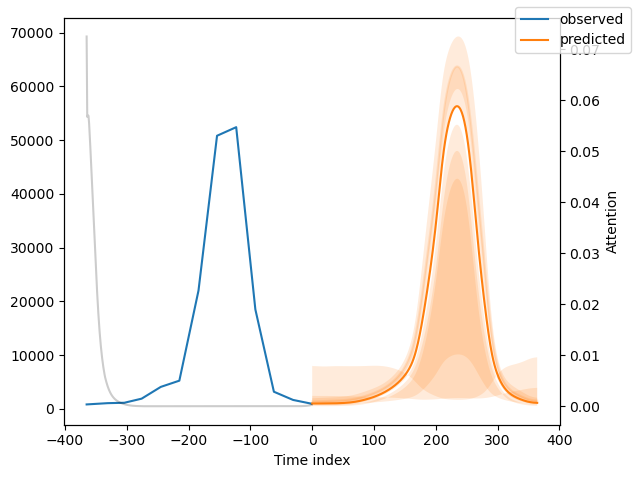

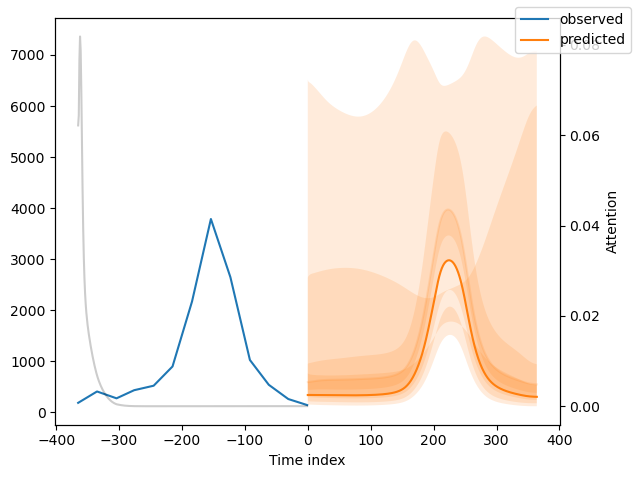

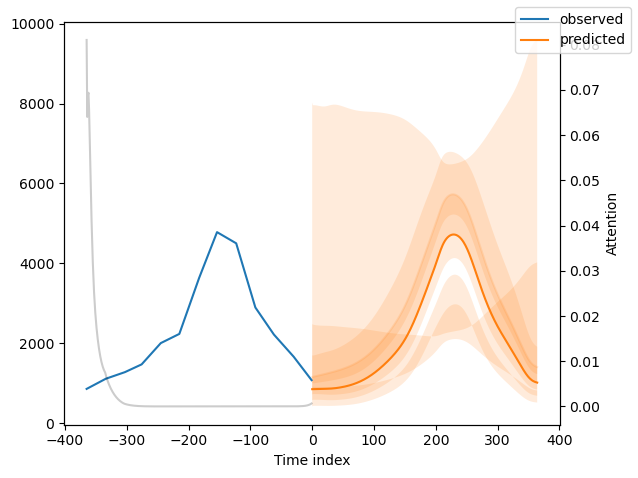

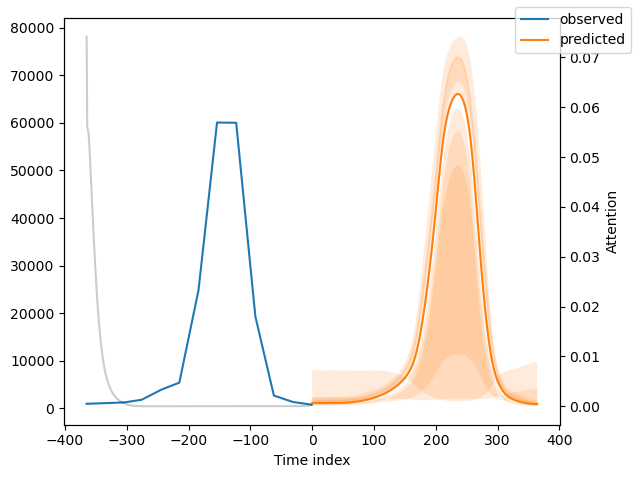

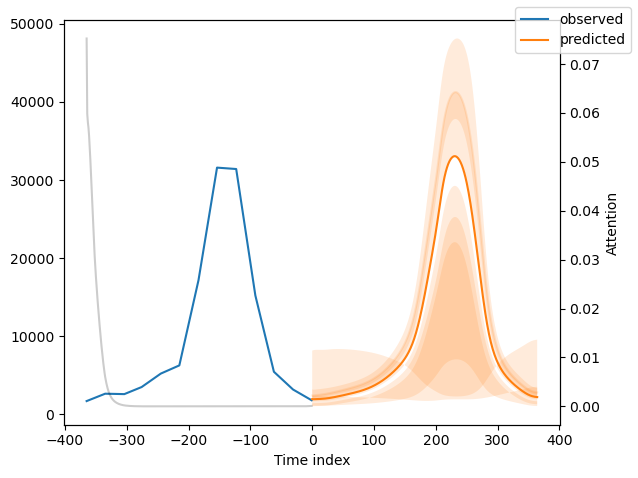

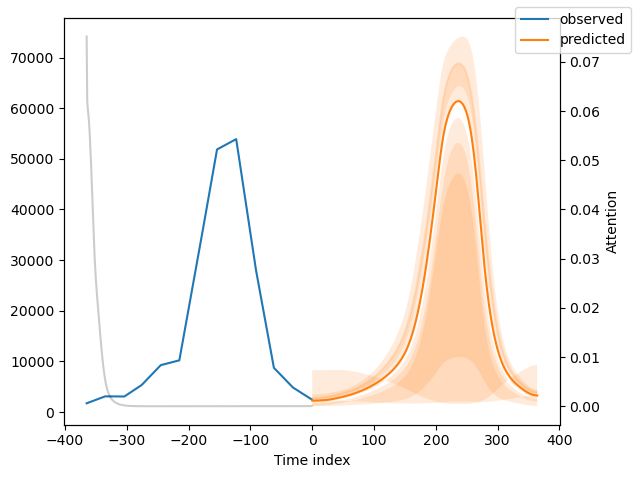

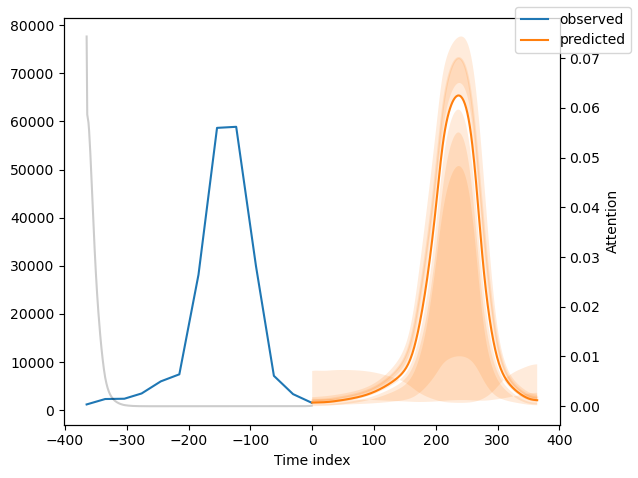

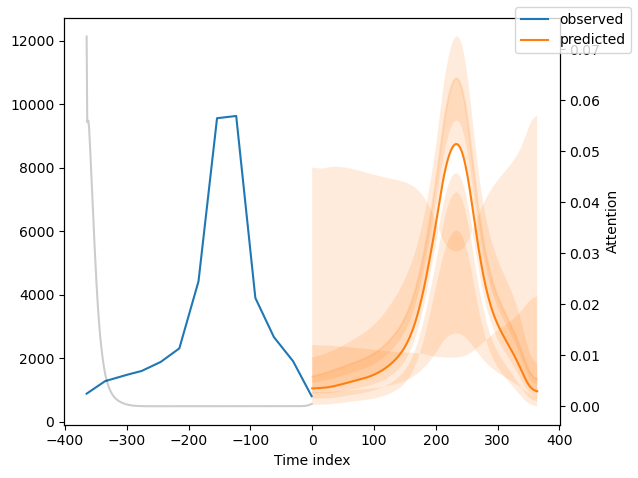

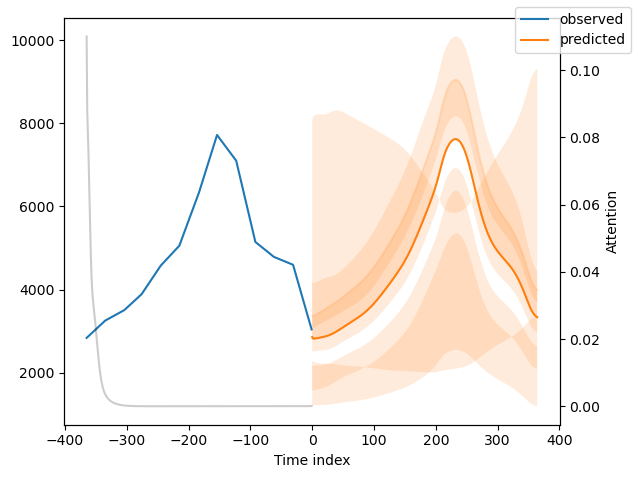

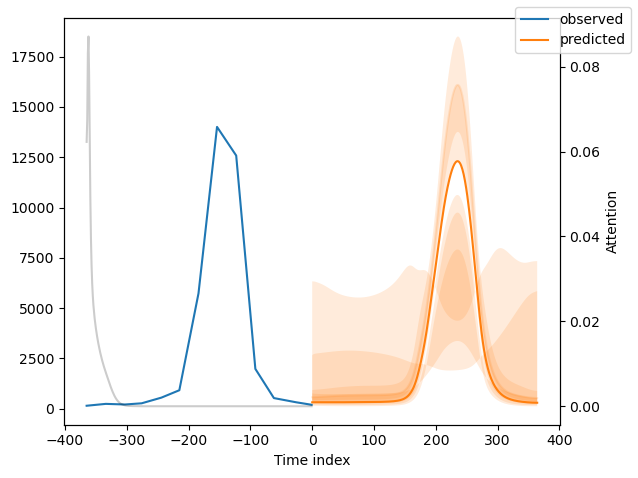

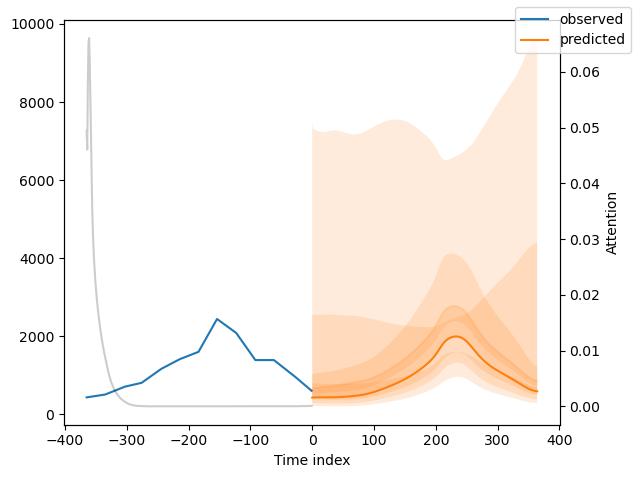

In [14]:
import matplotlib.pyplot as plt


pred, x = tft_model_id_hash_2_years.predict(df, mode="raw", return_x=True)
for idx in range(36):
    tft_model_id_hash_2_years.plot_prediction(x, pred, idx=idx, show_future_observed=False)

In [120]:
df_first_year = df[df['int_ind'] > 699][['city', 'id_hash', 'time']]
df_first_year['time'] = pd.to_datetime(df_first_year['time'])

In [121]:
pred, ind = tft_model_id_hash_2_years.predict(df, return_index=True)

pred = pd.DataFrame(pred.detach().numpy())
pred.index = ind.city

pred_T = pred.transpose()
date_range = pd.date_range(
    start=pd.to_datetime(df.time.max()) + np.timedelta64(1, 'D'),
    end=pd.to_datetime(df.time.max()) + np.timedelta64(365, 'D'))
pred_T['time_idx'] = date_range

In [122]:
ind = pred_T['time_idx']
train_names = pred_T.drop(columns=('time_idx')).columns
new_df = pd.DataFrame()
for i in train_names:
    some_df = pd.DataFrame()
    some_df['time'] = ind
    some_df['id_hash'] = pred_T[i]
    some_df['city'] = i
    year_1_df = pd.concat([df_first_year[df_first_year['city'] == i], some_df], ignore_index=True)
    year_1_df = year_1_df.sort_values('time')
#     year_1_df['int_ind'] = year_1_df.index
    new_df = pd.concat([new_df, year_1_df], ignore_index=True)
# new_df

In [123]:
new_df.to_csv('2_years_pred_without_trend.csv')

In [124]:
df_list = []


for root, dirs, files in os.walk(r"C:\Users\sahab\MF_TS"):  
    for filename in files:
        if '.csv' in filename:
            globals()[filename.replace('.csv', '')] = pd.read_csv("C:/Users/sahab/MF_TS/" + filename)
#             globals()[filename.replace('.csv', '')] = globals()[filename.replace('.csv', '')].set_index('Unnamed: 0')
            globals()[filename.replace('.csv', '')]  = globals()[filename.replace('.csv', '')]
            globals()[filename.replace('.csv', '')]['int_ind'] = globals()[filename.replace('.csv', '')].index
            globals()[filename.replace('.csv', '')]['city'] = filename.replace('.csv', '')
            globals()[filename.replace('.csv', '')]['time'] = globals()[filename.replace('.csv', '')]['Unnamed: 0']
            df_list.append(globals()[filename.replace('.csv', '')][['time', 'id_hash', 'mou_mean', 'dou_mean', 'city', 'int_ind']])

orig_df = pd.DataFrame()
for i in range(len(df_list)):
    if i == 0:
        orig_df = df_list[i].copy()
    else:
        orig_df = pd.concat([orig_df, df_list[i]], ignore_index=True)
        
orig_df.index = np.arange(len(orig_df))

orig_df.head()

time     id_hash    mou_mean     dou_mean                  city  \
0  2021-01-01  665.000000  362.671789  8926.977279  train_Abinsk_prepare   
1  2021-01-02  666.032258  362.840122  8890.981969  train_Abinsk_prepare   
2  2021-01-03  667.064516  363.008454  8854.986659  train_Abinsk_prepare   
3  2021-01-04  668.096774  363.176787  8818.991350  train_Abinsk_prepare   
4  2021-01-05  669.129032  363.345119  8782.996040  train_Abinsk_prepare   

   int_ind  
0        0  
1        1  
2        2  
3        3  
4        4

In [125]:
orig_df = orig_df[['city', 'id_hash', 'time']]

In [127]:
full_df = pd.concat([orig_df, new_df])

In [133]:
full_df['time'] = pd.to_datetime(full_df['time'])

train_Abinsk_prepare


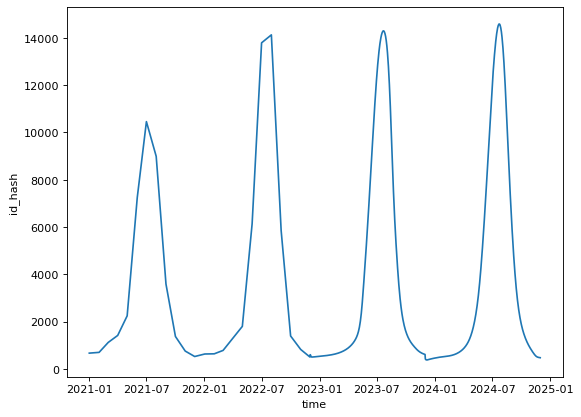

train_Alexandrov_prepare


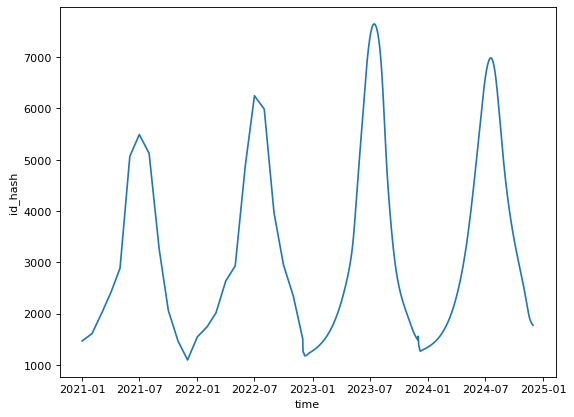

train_Armavir_prepare


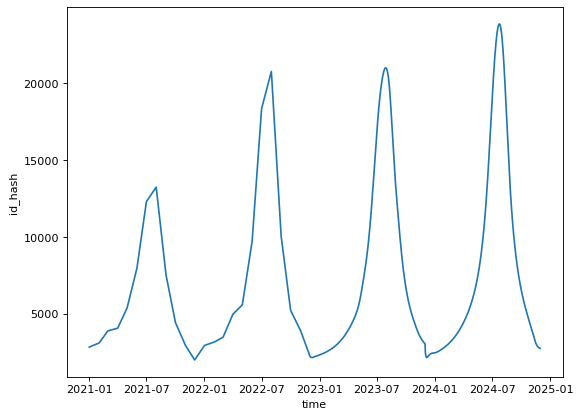

train_Baikalsk_prepare


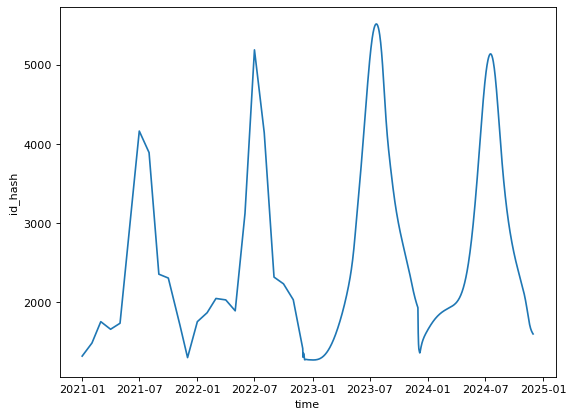

train_Belorechensk_prepare


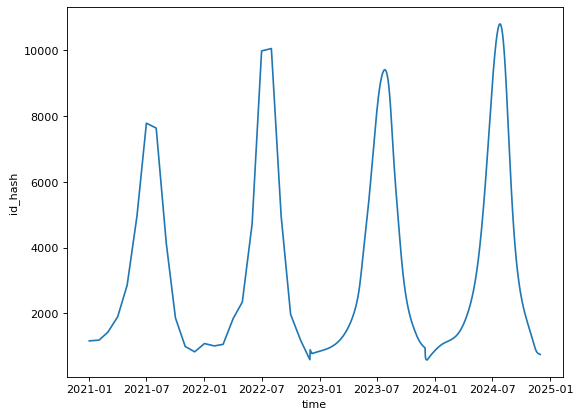

train_Gorno-Altaisk_prepare


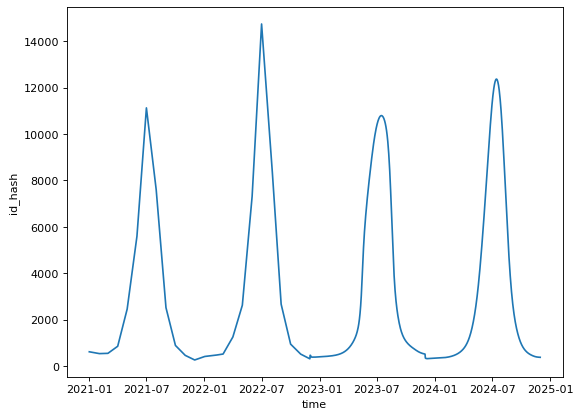

train_Gorodishchi_prepare


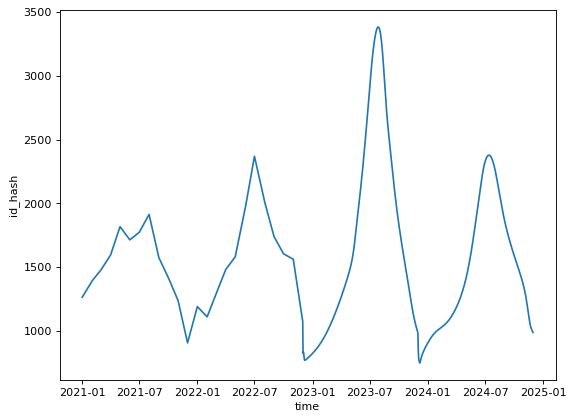

train_Gorokhovets_prepare


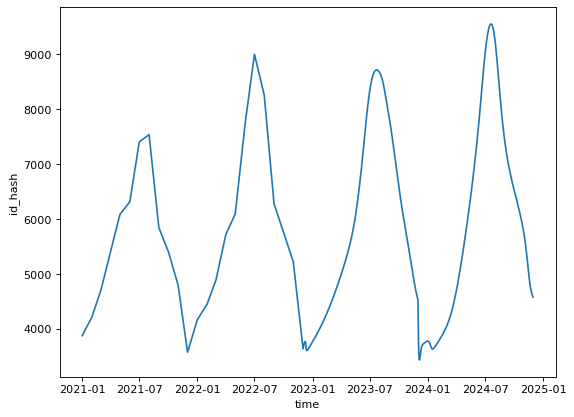

train_Gulkevichi_prepare


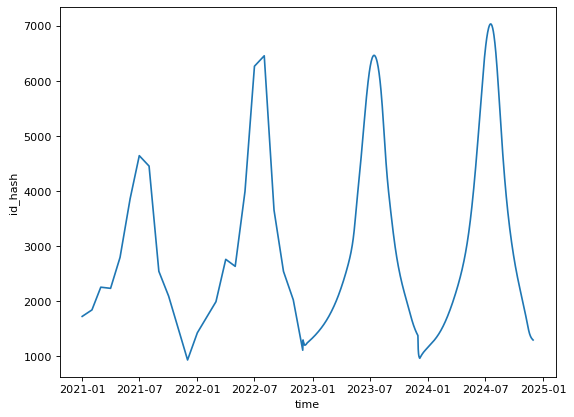

train_Hot Key_prepare


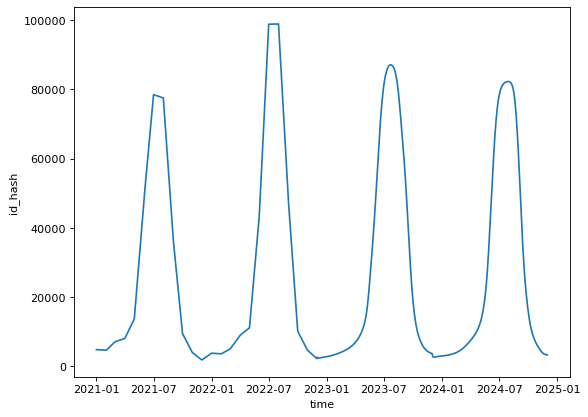

train_Khadyzhensk_prepare


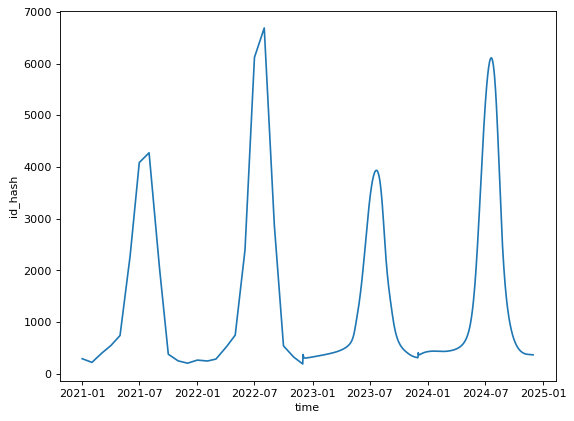

train_Kolchugino_prepare


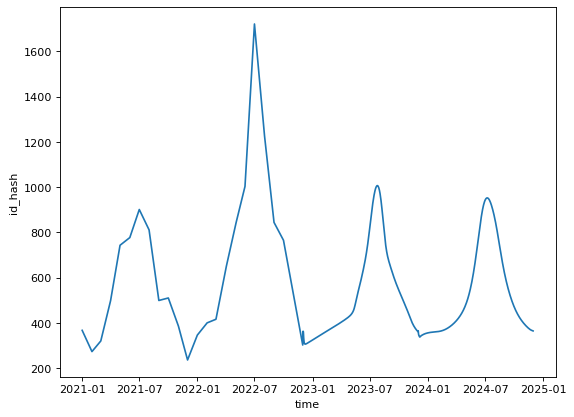

train_Korenovsk_prepare


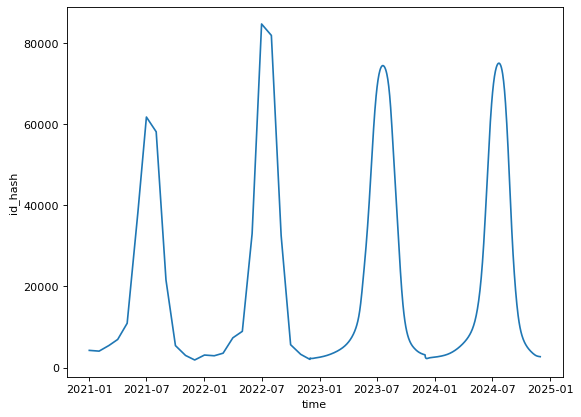

train_Kovrov_prepare


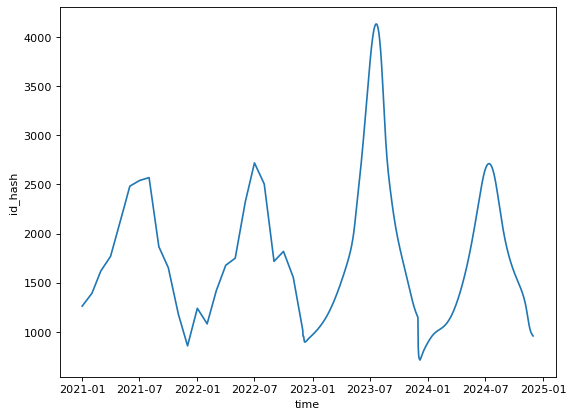

train_Kropotkin_prepare


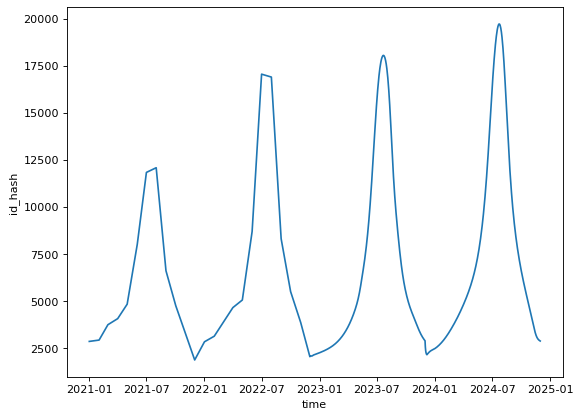

train_Krymsk_prepare


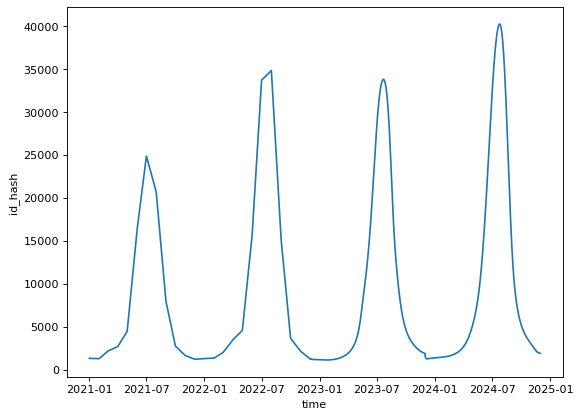

train_Kurganinsk_prepare


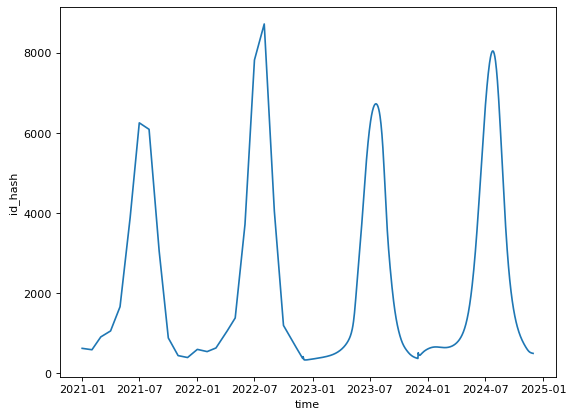

train_Labinsk_prepare


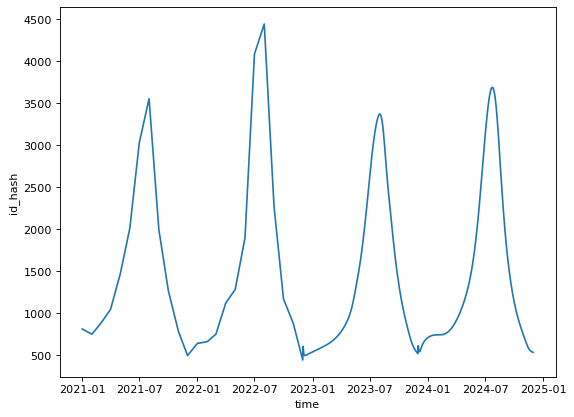

train_Lakinsk_prepare


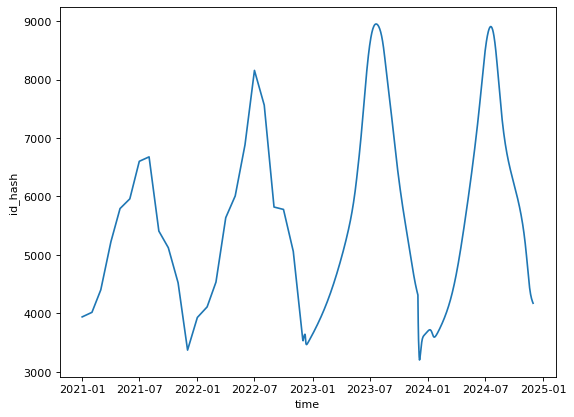

train_Melenki_prepare


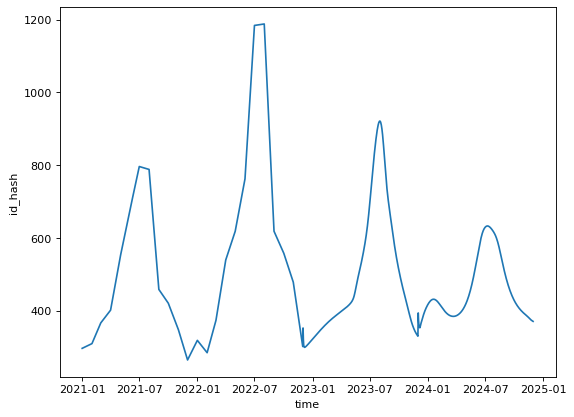

train_Murom_prepare


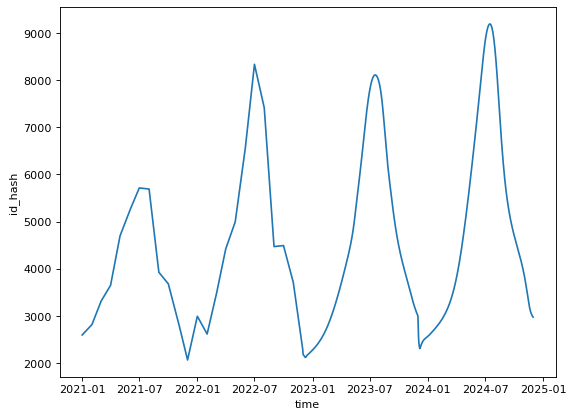

train_Novokubansk_prepare


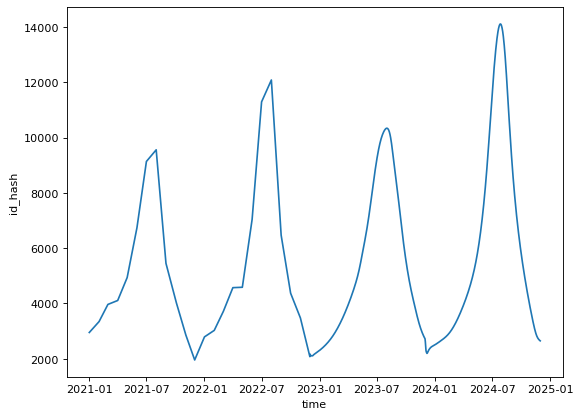

train_Petushki_prepare


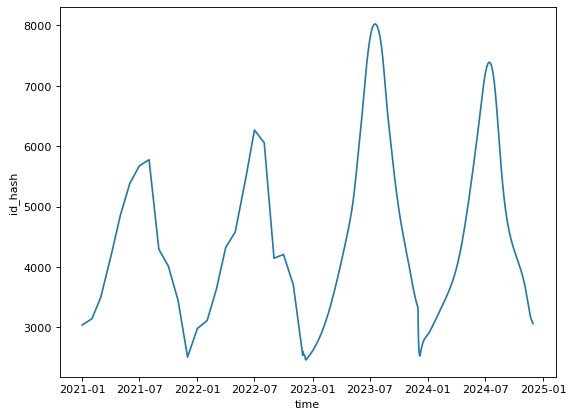

train_Pokrov_prepare


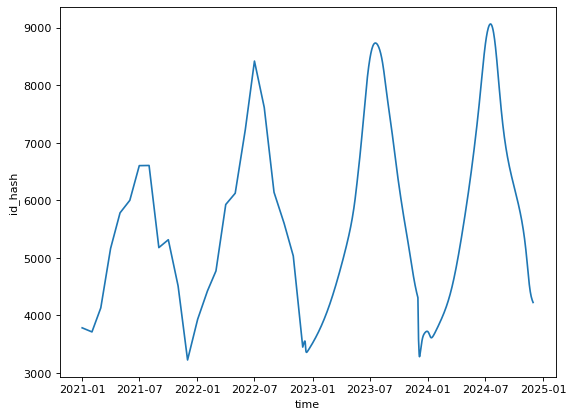

train_Sirius_prepare


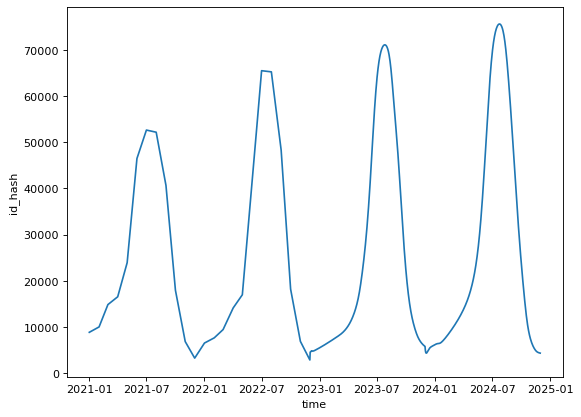

train_Slavyansk-on-Kuban_prepare


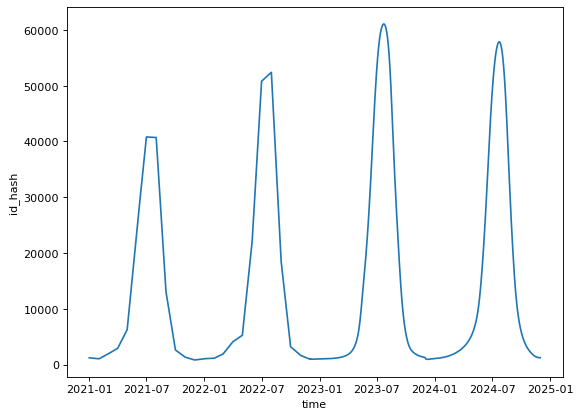

train_Sortavala_prepare


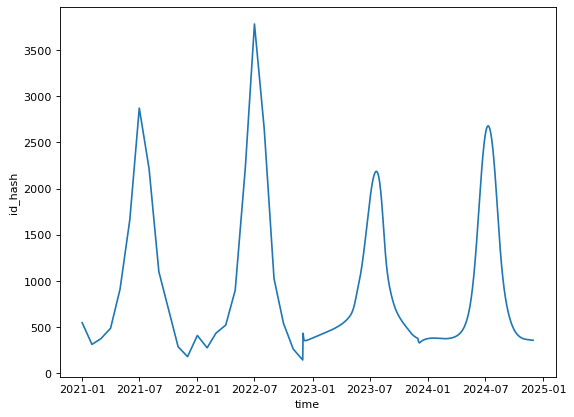

train_Strunino_prepare


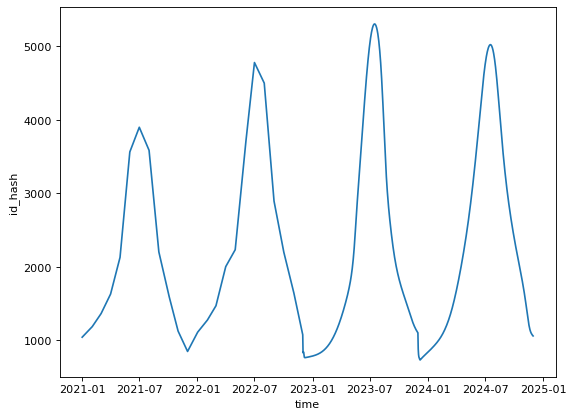

train_Temryuk_prepare


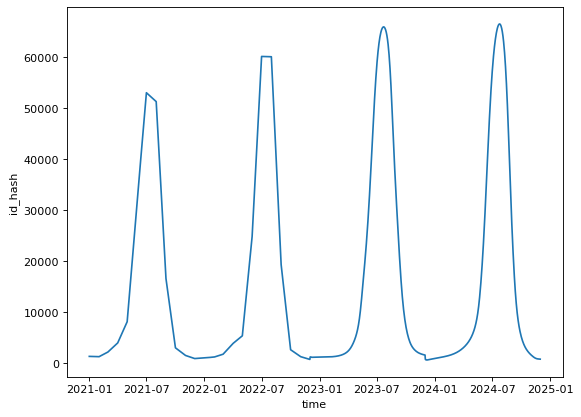

train_Tikhoretsk_prepare


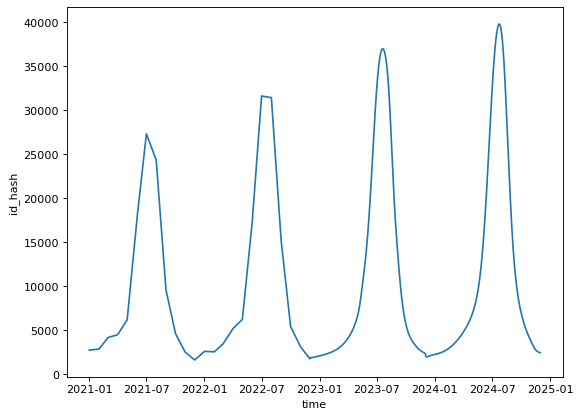

train_Timashevsk_prepare


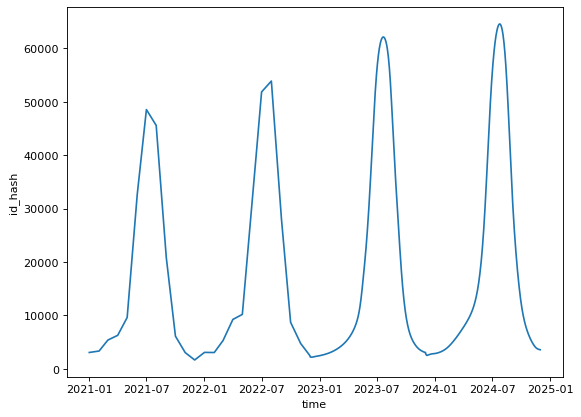

train_Tuapse_prepare


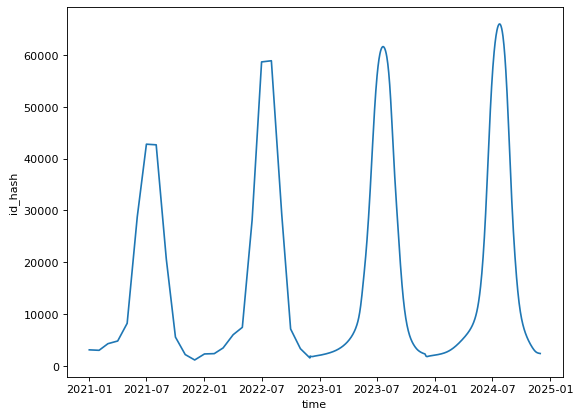

train_Ust-Labinsk_prepare


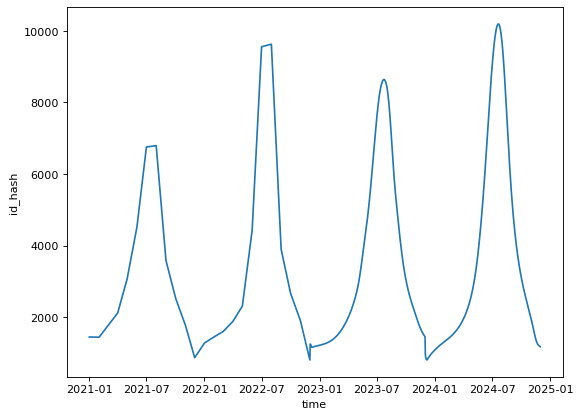

train_Vyazniki_prepare


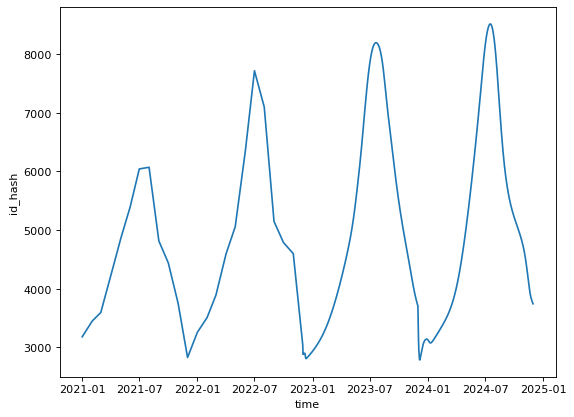

train_Yeisk_prepare


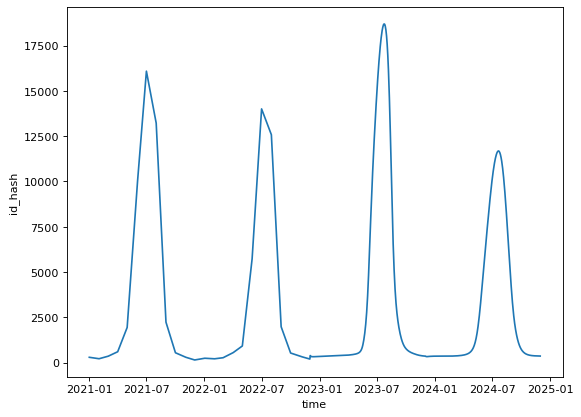

train_Yuriev-Polsky_prepare


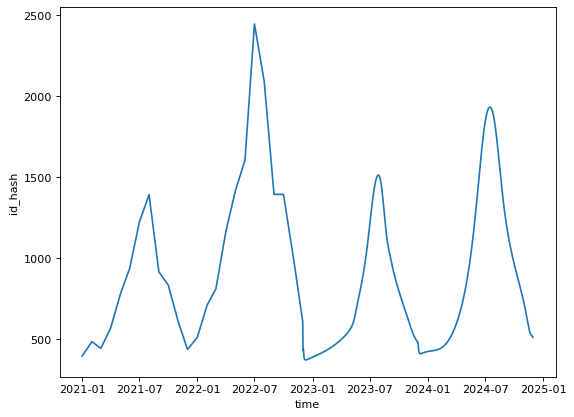

In [139]:
from matplotlib.pyplot import figure
import seaborn as sns


c_arr = orig_df.city.unique()
for i in c_arr:
    figure(figsize=(8, 6), dpi=80)
    print(i)
    sns.lineplot(y=full_df[full_df['city'] == i].id_hash, x=full_df[full_df['city'] == i].time)
    plt.show()

In [141]:
full_df.to_csv('duhota.csv')

In [157]:
full_df['month'] = full_df.time.dt.month
full_df['year'] = full_df.time.dt.year

In [161]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import calendar

In [172]:
sns.set_style("whitegrid")

df = full_df.copy()
cities = df.city.unique()

for city in cities:
    # создание сводной таблицы с количеством уникальных id по месяцам и годам
    pivot_table = pd.pivot_table(df[df['city'] == city], index='month', columns='year', values='id_hash', aggfunc='mean')

    # добавление столбца с процентным изменением количества абонентов
    pivot_table['%'] = (pivot_table[2023] - pivot_table[2022]) / pivot_table[2022] * 100

    # вывод таблицы
    pivot_table['abs_diff'] = pivot_table[2023] - pivot_table[2022]
    pivot_table = pivot_table.reset_index(drop=False)
    print(pivot_table)
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2022], name='2022'))
    fig.add_trace(go.Bar(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2023], name='2023'))
    fig.add_trace(go.Scatter(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2022].rolling(window=3).mean(),
                             mode='lines', name='Тренд 2022', line_color='blue'))
    fig.add_trace(go.Scatter(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2023].rolling(window=3).mean(),
                             mode='lines', name='Тренд 2023', line_color='red'))
    fig.update_layout(title=f'Ежемесячное количество абонентов в {city.replace("train_", "")} в 2022 и 2023 году',
                      xaxis_title='Месяц', yaxis_title='Количество абонентов')
    fig.show() 

year  month         2021          2022          2023          2024          %  \
0         1   680.483871    631.870968    552.363089    490.426732 -12.582930   
1         2   895.160714    705.428571    616.126520    549.675224 -12.659262   
2         3  1255.580645   1032.096774    753.763086    697.723475 -26.967790   
3         4  1813.683333   1540.250000   1093.212000   1175.043675 -29.023730   
4         5  4610.064516   3894.064516   3076.405213   3074.047040 -20.997580   
5         6  8740.666667   9832.883333   9073.086747   8484.309945  -7.727099   
6         7  9746.161290  13951.580645  13775.378774  13841.631521  -1.262953   
7         8  6374.645161  10120.000000   9836.062000  10442.995968  -2.805711   
8         9  2514.450000   3693.300000   2923.123410   3593.589766 -20.853345   
9        10  1070.451613   1119.516129   1177.655637   1277.768265   5.193271   
10       11   640.833333    671.983333    718.530229    588.937810   6.926793   
11       12   573.290323    

year  month         2021         2022         2023         2024          %  \
0         1  1534.225806  1640.322581  1345.595858  1410.036861 -17.967607   
1         2  1780.089286  1872.178571  1556.330775  1619.396312 -16.870602   
2         3  2172.612903  2312.967742  1923.277590  2014.217073 -16.848058   
3         4  2630.316667  2776.583333  2552.853233  2735.191406  -8.057748   
4         5  3939.806452  3852.225806  3963.881971  3981.433649   2.898484   
5         6  5271.416667  5518.983333  6334.870080  5708.773503  14.783280   
6         7  5314.870968  6121.709677  7532.859926  6865.941170  23.051571   
7         8  4242.967742  5008.129032  5814.063668  5806.198526  16.092529   
8         9  2701.150000  3473.416667  3258.087693  4058.858480  -6.199342   
9        10  1770.193548  2655.774194  2213.829761  2976.966466 -16.640889   
10       11  1283.100000  1938.450000  1675.897167  2056.365125 -13.544473   
11       12  1312.225806  1228.185445  1322.826327          NaN 

year  month          2021          2022          2023          2024  \
0         1   2945.645161   3028.451613   2442.706484   2591.863777   
1         2   3464.928571   3296.285714   2814.324082   3070.997954   
2         3   3957.193548   4183.935484   3437.662910   3849.838135   
3         4   4691.766667   5250.766667   4491.576287   5129.313867   
4         5   6632.290323   7569.774194   6836.698645   7563.059649   
5         6  10059.350000  13885.833333  12415.727000  13781.954036   
6         7  12752.290323  19526.935484  19594.664097  22494.170237   
7         8  10479.483871  15587.000000  17608.789903  17520.524698   
8         9   6027.516667   7712.150000   9520.693460   8720.177295   
9        10   3704.677419   4587.806452   5334.048397   5270.047033   
10       11   2477.683333   3098.400000   3534.873367   3226.783594   
11       12   2433.741935   2204.074606   2351.736541           NaN   

year          %     abs_diff  
0    -19.341406  -585.745129  
1    -14.62135

year  month         2021         2022         2023         2024          %  \
0         1  1397.838710  1807.677419  1278.370597  1739.564343 -29.281044   
1         2  1613.178571  1952.785714  1367.065246  1869.307571 -29.994098   
2         3  1706.548387  2037.290323  1609.504897  1945.593463 -20.997765   
3         4  1693.733333  1961.300000  2034.745257  2111.851685   3.744723   
4         5  2335.419355  2485.645161  2877.525881  2730.142625  15.765755   
5         6  3549.783333  4119.566667  4294.083677  4059.680119   4.236295   
6         7  4029.387097  4680.387097  5388.744642  5035.826077  15.134593   
7         8  3145.774194  3257.419355  4670.115635  4166.811901  43.368573   
8         9  2329.316667  2274.916667  3390.109213  2973.781372  49.021248   
9        10  2064.000000  2133.741935  2709.055794  2367.919189  26.962673   
10       11  1561.983333  1732.266667  2169.058157  1820.256047  25.215026   
11       12  1518.677419  1285.604594  1527.176748          NaN 

year  month         2021          2022         2023          2024          %  \
0         1  1179.129032   1052.161290   898.597106    999.556773 -14.595118   
1         2  1308.160714   1037.660714  1035.513329   1174.247424  -0.206945   
2         3  1659.967742   1434.096774  1322.267445   1421.822624  -7.797893   
3         4  2365.966667   2081.850000  1919.992877   2074.979240  -7.774677   
4         5  3874.290323   3498.709677  3570.797648   3590.227720   2.060416   
5         6  6320.350000   7262.950000  6465.611053   6831.321094 -10.978169   
6         7  7709.903226  10012.806452  9019.857594  10228.415638  -9.916789   
7         8  5976.225806   7587.129032  7768.666952   8438.864919   2.392709   
8         9  3077.516667   3516.250000  3955.939500   3753.575570  12.504501   
9        10  1447.032258   1599.483871  1914.454661   1902.424643  19.692027   
10       11   919.700000    908.550000  1147.546384    967.932123  26.305254   
11       12   957.451613    814.201923  

year  month         2021          2022          2023          2024          %  \
0         1   576.774194    434.741935    411.615417    348.699145  -5.319597   
1         2   541.785714    487.446429    456.286559    399.260356  -6.392471   
2         3   695.580645    873.645161    592.058695    567.700633 -32.231217   
3         4  1627.300000   1914.200000   1039.433528   1149.116089 -45.698802   
4         5  3973.387097   4889.387097   4067.714865   3400.104449 -16.805219   
5         6  8266.800000  10900.650000   8928.498583   8517.192839 -18.092053   
6         7  9419.354839  11950.483871  10622.892548  11862.207819 -11.109101   
7         8  5140.000000   5922.258065   6664.047361   6586.390995  12.525447   
8         9  1729.133333   1834.183333   1666.045247   1780.238944  -9.166918   
9        10   681.387097    739.838710    868.879771    666.337535  17.441783   
10       11   364.816667    419.983333    590.600317    411.293961  40.624703   
11       12   334.580645    

year  month         2021         2022         2023         2024          %  \
0         1  1326.451613  1153.290323   870.985737   961.160038 -24.478189   
1         2  1432.982143  1197.821429   988.876576  1033.064798 -17.443740   
2         3  1534.580645  1382.903226  1154.984971  1117.272571 -16.481143   
3         4  1703.300000  1530.333333  1370.113883  1282.014742 -10.469579   
4         5  1768.161290  1760.548387  1747.063826  1604.264093  -0.765930   
5         6  1743.516667  2153.033333  2456.959967  2105.475012  14.116207   
6         7  1841.741935  2202.064516  3223.920277  2349.731941  46.404442   
7         8  1750.451613  1887.064516  2983.860926  2068.644811  58.121829   
8         9  1500.600000  1675.750000  2167.195447  1722.888534  29.326895   
9        10  1332.419355  1585.193548  1605.647994  1477.369353   1.290344   
10       11  1079.016667  1327.616667  1157.795759  1144.409587 -12.791411   
11       12  1045.419355   807.173895   834.571486          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  4036.000000  4300.903226  3915.568684  3690.480721  -8.959386   
1         2  4441.982143  4658.696429  4269.928396  3874.736160  -8.344996   
2         3  5037.870968  5283.709677  4706.901713  4315.295489 -10.916723   
3         4  5737.216667  5893.150000  5247.847897  5185.498633 -10.950037   
4         5  6195.870968  6880.161290  6053.034232  6413.198478 -12.021914   
5         6  6840.283333  8341.183333  7519.807610  8053.969531  -9.847233   
6         7  7469.354839  8642.000000  8619.713645  9403.917339  -0.257884   
7         8  6717.354839  7300.419355  8344.678587  8352.830929  14.304099   
8         9  5632.233333  6025.733333  7266.860320  6940.810221  20.597111   
9        10  5110.903226  5495.645161  6048.513265  6169.424017  10.060113   
10       11  4202.400000  4482.883333  4993.555790  5082.332747  11.391607   
11       12  3856.935484  3681.158206  3711.677762          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  1783.096774  1573.193548  1429.552652  1256.897028  -9.130529   
1         2  2042.642857  1855.250000  1660.904704  1511.574741 -10.475424   
2         3  2245.838710  2364.612903  1997.888252  1918.343974 -15.508866   
3         4  2506.150000  2699.616667  2502.962763  2509.039998  -7.284512   
4         5  3298.258065  3291.580645  3511.890765  3558.616313   6.693141   
5         6  4224.050000  5090.166667  5336.158053  5468.945150   4.832678   
6         7  4549.548387  6354.451613  6355.570261  6881.133049   0.017604   
7         8  3528.774194  5098.129032  5025.251623  5517.690430  -1.429493   
8         9  2335.683333  3116.533333  3201.691033  3434.707829   2.732450   
9        10  1826.064516  2292.806452  2233.742326  2325.062551  -2.576062   
10       11  1237.733333  1585.233333  1611.443333  1532.586621   1.653384   
11       12  1174.548387  1257.824439  1074.438087          NaN 

year  month          2021          2022          2023          2024  \
0         1   4753.161290   3719.387097   3133.515526   3207.398579   
1         2   5845.392857   4319.839286   4057.579279   4007.466889   
2         3   7574.032258   6946.741935   5590.903200   5981.895602   
3         4  10788.716667  10010.116667   9063.678350   9525.984115   
4         5  30544.387097  26717.193548  24630.297968  21751.570123   
5         6  63002.950000  70157.583333  63396.238433  62657.925521   
6         7  78021.580645  98864.354839  85726.969839  81333.044607   
7         8  57938.806452  74428.741935  77429.649903  76100.159400   
8         9  23704.166667  29857.316667  41019.336067  33647.688607   
9        10   6806.258065   7478.903226  10771.421448   9407.812941   
10       11   2959.316667   3482.316667   4554.963723   4085.729362   
11       12   2795.935484   2575.355455   2862.607918           NaN   

year          %      abs_diff  
0    -15.751831   -585.871571  
1     -6.071

year  month         2021         2022         2023         2024          %  \
0         1   257.645161   255.806452   342.173544   436.444057  33.762672   
1         2   299.589286   264.803571   377.441713   434.098292  42.536489   
2         3   459.483871   390.967742   423.236763   452.512347   8.253628   
3         4   637.150000   621.933333   509.598679   546.862641 -18.062170   
4         5  1456.645161  1544.451613   938.410852  1081.441942 -39.239867   
5         6  3121.900000  4194.900000  2385.028353  3479.008838 -43.144572   
6         7  4177.451613  6395.322581  3777.564432  5844.857312 -40.932386   
7         8  3255.967742  4882.225806  2741.585555  3759.387341 -43.845581   
8         9  1303.350000  1787.750000  1025.854278  1117.949019 -42.617576   
9        10   316.064516   438.387097   484.837800   494.140701  10.595819   
10       11   228.250000   262.333333   341.908061   376.549139  30.333441   
11       12   234.032258   311.742196   397.731642          NaN 

year  month        2021         2022        2023        2024          %  \
0         1  321.516129   372.129032  337.481907  358.735612  -9.310514   
1         2  295.660714   407.714286  362.760546  365.903273 -11.025795   
2         3  406.129032   523.419355  387.954907  389.302472 -25.880672   
3         4  616.416667   729.350000  416.160580  439.548557 -42.940895   
4         5  759.451613   912.161290  488.399722  563.442541 -46.456868   
5         6  836.933333  1350.033333  674.682744  827.241520 -50.024734   
6         7  857.451613  1487.290323  946.939505  926.522876 -36.331227   
7         8  660.032258  1047.354839  815.932178  740.069740 -22.095917   
8         9  504.316667   805.816667  604.897811  537.535184 -24.933569   
9        10  452.419355   651.290323  496.250631  430.732283 -23.805005   
10       11  316.083333   419.800000  396.443872  377.815528  -5.563632   
11       12  289.225806   317.007924  348.796726         NaN  10.027763   

year    abs_diff  
0    

year  month          2021          2022          2023          2024  \
0         1   4133.967742   2989.870968   2814.689161   2752.856540   
1         2   4626.732143   3201.750000   3624.691386   3438.099643   
2         3   6061.709677   5364.290323   5004.924684   4908.709575   
3         4   8847.016667   8095.366667   8059.594540   7581.855811   
4         5  22872.193548  20567.290323  20299.511355  15943.831212   
5         6  48254.316667  57975.916667  51470.345200  46979.115365   
6         7  59985.645161  83320.483871  72991.231290  73021.361391   
7         8  40441.419355  57985.000000  59966.237387  57901.983619   
8         9  13768.416667  19516.166667  23320.139433  18366.045085   
9        10   4246.000000   4494.129032   6492.024965   5766.203346   
10       11   2455.266667   2671.816667   3656.692383   3106.932471   
11       12   2447.354839   2336.337016   2429.994846           NaN   

year          %      abs_diff  
0     -5.859176   -175.181806  
1     13.209

year  month         2021         2022         2023         2024          %  \
0         1  1324.387097  1162.548387  1021.721171   956.204102 -12.113665   
1         2  1500.964286  1239.142857  1157.940571  1041.298241  -6.553101   
2         3  1690.580645  1538.677419  1362.604584  1169.834701 -11.443129   
3         4  1935.233333  1711.800000  1644.137553  1438.100814  -3.952707   
4         5  2292.064516  2019.967742  2155.465513  1856.139381   6.707918   
5         6  2509.550000  2507.166667  3123.161450  2401.244271  24.569359   
6         7  2553.516129  2614.967742  4011.914755  2674.722073  53.421195   
7         8  2228.838710  2123.193548  3258.446865  2265.021693  53.469139   
8         9  1762.566667  1765.816667  2199.810063  1768.333167  24.577489   
9        10  1427.483871  1690.258065  1700.234061  1486.075046   0.590206   
10       11  1028.016667  1294.933333  1303.099007  1123.247632   0.630586   
11       12  1041.838710   932.529275   806.539275          NaN 

year  month          2021          2022          2023          2024  \
0         1   2872.354839   2961.709677   2350.810739   2678.249803   
1         2   3302.910714   3460.214286   2652.650571   3325.326483   
2         3   3882.290323   4220.032258   3189.414848   4231.644539   
3         4   4419.716667   4830.266667   4192.719787   5436.547982   
4         5   6290.838710   6800.290323   6397.898181   7462.762790   
5         6   9776.550000  12722.083333  11622.912100  12372.999447   
6         7  11941.483871  16969.000000  17392.940065  18760.309948   
7         8   9419.838710  12730.129032  13748.084581  14929.656628   
8         9   5719.133333   6936.316667   7245.960820   8334.529899   
9        10   4059.677419   4719.032258   4617.298290   5424.539393   
10       11   2592.416667   2995.750000   3332.976193   3360.983944   
11       12   2318.903226   2133.699961   2330.714866           NaN   

year          %     abs_diff  
0    -20.626564  -610.898939  
1    -23.33854

year  month          2021          2022          2023          2024  \
0         1   1288.645161   1304.290323   1123.619797   1403.357319   
1         2   1699.035714   1657.839286   1185.428821   1589.470341   
2         3   2407.806452   2706.806452   1528.383723   2108.798954   
3         4   3526.466667   3989.900000   2653.430557   3728.665031   
4         5  10099.419355   9906.483871   7617.611687   8535.630796   
5         6  20340.450000  24341.716667  19563.631867  22464.973665   
6         7  22820.709677  34209.870968  32304.051871  37950.349294   
7         8  14503.548387  25267.903226  22746.050194  28277.366463   
8         9   5415.566667   9557.016667   7764.633967   8538.708740   
9        10   2200.709677   2906.774194   3505.896294   3956.167095   
10       11   1427.133333   1720.666667   2196.060580   2315.359741   
11       12   1236.000000   1181.316023   1321.948069           NaN   

year          %     abs_diff  
0    -13.852018  -180.670526  
1    -28.49555

year  month         2021         2022         2023         2024          %  \
0         1   610.064516   574.387097   379.454266   647.258675 -33.937536   
1         2   746.285714   589.392857   425.244517   650.886527 -27.850412   
2         3   984.096774   813.580645   512.406536   684.423259 -37.018347   
3         4  1352.933333  1187.633333   725.523036   933.073167 -38.910182   
4         5  2699.516129  2514.838710  1807.268220  1969.819159 -28.135820   
5         6  4985.716667  5700.216667  4711.269867  4782.858854 -17.349284   
6         7  6171.612903  8251.516129  6565.162787  7605.347514 -20.436891   
7         8  4655.258065  6505.645161  4935.882255  6290.201424 -24.129243   
8         9  2043.850000  2722.683333  1854.739603  2586.734823 -31.878247   
9        10   673.096774   991.387097   739.587389  1070.142560 -25.398728   
10       11   422.800000   579.116667   431.669698   583.954290 -25.460667   
11       12   496.225806   350.828417   522.049746          NaN 

year  month         2021         2022         2023         2024          %  \
0         1   781.516129   649.677419   565.896279   731.202737 -12.895806   
1         2   811.196429   703.875000   623.596448   746.228293 -11.405228   
2         3   958.806452   929.548387   709.520282   824.037824 -23.670431   
3         4  1242.200000  1197.816667   871.891223  1042.072418 -27.209961   
4         5  1722.032258  1578.096774  1267.180406  1471.031451 -19.701984   
5         6  2500.550000  2951.083333  2056.095167  2427.733643 -30.327445   
6         7  3279.064516  4253.225806  3066.174713  3515.170804 -27.909430   
7         8  2796.580645  3389.451613  2985.179248  2867.102602 -11.927368   
8         9  1643.583333  1738.366667  1832.089887  1529.151628   5.391453   
9        10  1038.677419  1028.193548  1050.952954   914.761687   2.213533   
10       11   648.966667   667.750000   625.953530   600.766085  -6.259299   
11       12   565.161290   516.886257   625.180496          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  3977.741935  4017.580645  3805.563823  3659.361635  -5.277226   
1         2  4203.625000  4315.428571  4172.009971  3825.626027  -3.323392   
2         3  4790.580645  5068.225806  4633.119871  4308.902950  -8.584975   
3         4  5488.683333  5816.800000  5225.885167  5146.875830 -10.158761   
4         5  5873.322581  6431.903226  6129.759616  6280.484926  -4.697577   
5         6  6269.300000  7498.283333  7734.679527  7683.928971   3.152671   
6         7  6637.774194  7868.580645  8859.838645  8781.884608  12.597672   
7         8  6062.967742  6718.612903  8406.498665  7786.951109  25.122533   
8         9  5270.250000  5799.183333  7035.327093  6558.285970  21.315825   
9        10  4832.677419  5431.064516  5758.900235  5848.731839   6.036307   
10       11  3966.683333  4332.616667  4744.513923  4680.510303   9.506894   
11       12  3642.000000  3554.961523  3561.439210          NaN 

year  month        2021         2022        2023        2024          %  \
0         1  302.290323   301.548387  336.154099  426.878856  11.476006   
1         2  336.482143   326.910714  363.522479  408.736506  11.199316   
2         3  382.935484   453.322581  385.979582  386.185084 -14.855426   
3         4  470.600000   577.183333  406.987001  397.688063 -29.487396   
4         5  607.903226   687.677419  457.878953  461.571834 -33.416608   
5         6  733.483333   965.966667  587.331708  584.129720 -39.197518   
6         7  792.129032  1185.935484  822.241826  626.127294 -30.667238   
7         8  628.322581   912.193548  822.186875  564.132772  -9.867059   
8         9  439.633333   589.966667  595.475409  462.927906   0.933738   
9        10  386.129032   520.322581  456.656120  408.358373 -12.235960   
10       11  308.433333   392.450000  359.490405  380.864709  -8.398419   
11       12  290.129032   309.451241  381.813232         NaN  23.383972   

year    abs_diff  
0    

year  month         2021         2022         2023         2024          %  \
0         1  2698.935484  2807.096774  2394.082077  2665.833252 -14.713233   
1         2  3047.321429  3000.125000  2739.048004  2929.525567  -8.702204   
2         3  3467.387097  3902.806452  3292.152910  3397.155478 -15.646524   
3         4  4154.500000  4697.466667  4049.084100  4375.705062 -13.802814   
4         5  4959.258065  5721.709677  5186.466265  5952.051789  -9.354606   
5         6  5468.583333  7388.816667  6945.483823  7860.015723  -6.000052   
6         7  5703.354839  7893.870968  8022.183087  9050.346459   1.625465   
7         8  4836.516129  5991.064516  7026.146126  7309.197927  17.277090   
8         9  3805.100000  4479.633333  5167.416243  5234.887988  15.353554   
9        10  3295.741935  4113.096774  4067.955110  4331.511837  -1.097510   
10       11  2488.283333  3021.733333  3313.506703  3355.585620   9.655828   
11       12  2510.516129  2185.784306  2481.388704          NaN 

year  month         2021          2022         2023          2024          %  \
0         1  3142.129032   2905.709677  2463.603013   2620.366022 -15.215101   
1         2  3644.928571   3346.660714  2880.701743   2931.413877 -13.923102   
2         3  4034.709677   4116.774194  3513.652910   3521.798883 -14.650337   
3         4  4508.683333   4578.766667  4406.878437   4428.023966  -3.754029   
4         5  5808.451613   5773.419355  5797.164294   5956.421481   0.411280   
5         6  7896.550000   9094.166667  7953.092267   9202.673861 -12.547322   
6         7  9338.709677  11672.741935  9915.755097  13310.259325 -15.052049   
7         8  7569.225806   9366.000000  9673.501935  11922.223318   3.283172   
8         9  4816.833333   5455.966667  6999.291497   7345.366341  28.286918   
9        10  3551.129032   3938.935484  4632.805000   4704.779628  17.615661   
10       11  2456.100000   2800.333333  3193.001407   3031.705558  14.022190   
11       12  2361.032258   2179.675961  

year  month         2021         2022         2023         2024          %  \
0         1  3088.806452  3043.870968  2756.253945  3020.993692  -9.449054   
1         2  3314.160714  3347.767857  3146.782754  3344.825768  -6.003556   
2         3  3813.000000  3951.322581  3705.151468  3716.880623  -6.230094   
3         4  4482.500000  4447.766667  4405.643043  4334.181340  -0.947074   
4         5  5102.709677  4974.806452  5408.583439  5334.175387   8.719475   
5         6  5523.683333  5817.983333  6998.105673  6562.592839  20.284045   
6         7  5723.322581  6165.419355  7948.783632  7284.967017  28.925271   
7         8  5058.935484  5130.838710  7166.944035  6002.455220  39.683674   
8         9  4159.116667  4174.450000  5622.204817  4616.461768  34.681331   
9        10  3739.225806  3965.064516  4518.505458  4043.988620  13.957930   
10       11  2991.116667  3141.500000  3682.360477  3371.166032  17.216631   
11       12  2735.870968  2529.297865  2756.424687          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  3746.645161  4153.516129  3670.009732  3673.026517 -11.640894   
1         2  3911.535714  4583.053571  4042.450775  3957.552431 -11.795690   
2         3  4627.354839  5328.870968  4531.502000  4463.868511 -14.963188   
3         4  5459.666667  6019.733333  5148.530167  5311.163411 -14.472454   
4         5  5885.483871  6636.322581  6064.863403  6427.310043  -8.611082   
5         6  6289.450000  7781.950000  7646.554673  7862.067676  -1.739864   
6         7  6602.451613  8029.000000  8659.329742  8944.523753   7.850663   
7         8  5913.032258  6899.290323  8164.342152  7895.635522  18.335970   
8         9  5242.216667  5895.366667  6940.323717  6615.907243  17.725056   
9        10  4923.967742  5343.258065  5759.109577  5873.220120   7.782733   
10       11  3886.950000  4264.916667  4742.754277  4727.628581  11.203914   
11       12  3556.838710  3445.260003  3605.954971          NaN 

year  month          2021          2022          2023          2024  \
0         1   9441.161290   7099.354839   6144.073452   6626.861486   
1         2  12372.750000   8542.071429   7418.697064   8695.503064   
2         3  15691.258065  11685.580645   8969.494710  11825.498708   
3         4  20129.516667  15476.350000  12350.895900  16433.098470   
4         5  34844.580645  28788.548387  22386.215065  27309.053238   
5         6  49447.466667  53013.750000  47548.929000  54596.060937   
6         7  52400.516129  65346.064516  69006.852581  74000.028982   
7         8  46584.354839  57026.483871  63833.372484  66774.299143   
8         9  29678.866667  33753.783333  37685.748800  38555.361849   
9        10  12598.870968  12747.225806  14596.390355  14000.912739   
10       11   5143.216667   4971.066667   7167.282510   5222.152100   
11       12   4870.870968   4949.010487   5380.720751           NaN   

year          %     abs_diff  
0    -13.455890  -955.281387  
1    -13.15107

year  month          2021          2022          2023          2024  \
0         1   1113.677419   1086.645161   1017.740011   1175.478697   
1         2   1435.892857   1498.357143   1114.348575   1570.970497   
2         3   2376.741935   2953.193548   1427.895571   2416.292122   
3         4   4526.850000   4642.700000   2824.161133   4209.181478   
4         5  14938.935484  13352.129032  12441.027113  10320.949361   
5         6  32232.200000  35927.383333  37286.812100  33361.891406   
6         7  40764.612903  51584.225806  59010.982129  55505.662298   
7         8  27339.290323  36001.419355  46818.563000  42549.946573   
8         9   8015.916667  11096.300000  15084.353557  12801.223258   
9        10   1983.354839   2444.096774   3129.929355   3615.468655   
10       11   1072.883333   1316.250000   1517.783937   1501.593840   
11       12    925.741935    977.182742    997.578987           NaN   

year          %      abs_diff  
0     -6.341090    -68.905150  
1    -25.628

year  month         2021         2022         2023         2024           %  \
0         1   430.290323   341.161290   399.466698   376.191777   17.090276   
1         2   338.410714   348.660714   442.462507   372.333302   26.903459   
2         3   425.161290   473.580645   490.945559   380.461016    3.666728   
3         4   688.933333   701.216667   565.653862   449.512042  -19.332513   
4         5  1272.838710  1511.967742   792.193430   811.158550  -47.605137   
5         6  2246.833333  2950.066667  1411.824810  1961.560323  -52.142613   
6         7  2554.580645  3233.387097  2093.392835  2556.560311  -35.256968   
7         8  1675.032258  1860.161290  1504.426321  1469.521006  -19.123878   
8         9   906.116667   788.100000   762.598515   632.644483   -3.235818   
9        10   499.225806   402.000000   541.238564   405.895185   34.636459   
10       11   231.800000   200.966667   413.522809   360.044944  105.766865   
11       12   287.290323   357.276411   351.834221  

year  month         2021         2022         2023         2024          %  \
0         1  1108.774194  1184.354839   810.212627   901.319706 -31.590381   
1         2  1264.375000  1365.910714   906.457361  1074.544690 -33.637144   
2         3  1487.580645  1727.903226  1123.052529  1409.202129 -35.004894   
3         4  1870.666667  2114.166667  1518.214997  2004.133167 -28.188491   
4         5  2823.354839  2891.548387  2495.107458  2882.465371 -13.710334   
5         6  3726.400000  4167.716667  4256.172260  4115.719889   2.122399   
6         7  3748.064516  4645.516129  5207.413032  4938.712591  12.095468   
7         8  2916.806452  3723.903226  3860.161584  4095.028509   3.659020   
8         9  1930.400000  2567.300000  2235.806613  2835.466919 -12.912141   
9        10  1390.290323  1958.129032  1636.957377  2050.010691 -16.401966   
10       11   991.116667  1388.616667  1247.287447  1295.245467 -10.177699   
11       12   972.354839   789.394275   793.923455          NaN 

year  month          2021          2022          2023          2024  \
0         1   1357.903226   1170.322581   1255.268613   1147.776365   
1         2   1767.267857   1524.071429   1353.733318   1574.793735   
2         3   3099.290323   2817.000000   1816.014703   2396.286448   
3         4   6022.866667   4626.083333   3937.139983   4232.672559   
4         5  19342.935484  14809.806452  14623.174068  11018.193470   
5         6  41762.033333  41869.983333  41757.487000  39187.024479   
6         7  52143.483871  60055.419355  63962.422613  63921.098412   
7         8  34488.645161  40332.935484  51376.131548  50867.927356   
8         9  10061.866667  11284.816667  17865.154150  13281.035840   
9        10   2347.258065   2037.677419   4263.657494   3093.262227   
10       11   1283.950000   1075.750000   1980.477033   1108.255756   
11       12   1022.903226   1216.535452    832.554401           NaN   

year           %      abs_diff  
0       7.258343     84.946032  
1     -11.

year  month          2021          2022          2023          2024  \
0         1   2820.516129   2594.354839   2257.624965   2432.119227   
1         2   3508.375000   3003.339286   2664.830096   3002.323082   
2         3   4340.129032   4306.193548   3447.230161   4064.822297   
3         4   5332.700000   5703.016667   5141.129777   5805.061637   
4         5  11758.548387  11525.483871  10208.718374   9767.694651   
5         6  22323.766667  24128.633333  23389.746300  22652.285482   
6         7  25851.967742  31493.387097  35804.903097  37753.256048   
7         8  17201.193548  23562.774194  26384.931710  28538.552986   
8         9   7214.150000  10479.350000  10040.822540  10806.274268   
9        10   3621.838710   4329.225806   4275.442619   5196.491439   
10       11   2097.666667   2490.866667   2782.334333   2917.191325   
11       12   2115.741935   1978.783261   2141.000398           NaN   

year          %     abs_diff  
0    -12.979330  -336.729874  
1    -11.27109

year  month          2021          2022          2023          2024  \
0         1   3201.129032   3071.935484   2699.097500   3135.191674   
1         2   4332.285714   4147.642857   3379.907086   4301.608171   
2         3   5823.290323   7222.032258   4607.487003   6444.844223   
3         4   7893.300000   9711.683333   7075.251753   9321.004720   
4         5  20523.548387  20324.580645  15823.358355  15713.615959   
5         6  40080.666667  41144.883333  40456.190433  38877.527604   
6         7  47120.774194  52845.612903  60568.566581  62101.775706   
7         8  33864.419355  41714.129032  49473.198065  52253.374244   
8         9  13989.000000  19050.850000  20463.767867  21673.314128   
9        10   4628.064516   6829.419355   6609.390277   8162.653935   
10       11   2375.966667   3689.833333   3613.432140   4191.622892   
11       12   2351.580645   2308.877735   2747.055752           NaN   

year          %     abs_diff  
0    -12.136908  -372.837984  
1    -18.51017

year  month          2021          2022          2023          2024  \
0         1   3052.935484   2334.516129   2255.297200   2258.257923   
1         2   3622.696429   2894.910714   2816.476586   2930.405955   
2         3   4536.096774   4678.000000   3876.806013   4341.110879   
3         4   6454.133333   6682.083333   6152.754353   6501.069287   
4         5  17929.258065  17460.935484  14933.340306  12191.009388   
5         6  35296.850000  42900.400000  39969.301133  37006.476237   
6         7  42729.451613  58774.419355  60073.149290  63285.333921   
7         8  32262.806452  45261.741935  48077.505419  51863.336316   
8         9  13621.616667  19318.850000  19205.063500  18630.186133   
9        10   3926.387097   5285.322581   5726.768748   6256.914409   
10       11   1680.916667   2460.250000   2789.189053   2910.635929   
11       12   1704.225806   1889.053977   1955.458187           NaN   

year          %     abs_diff  
0     -3.393377   -79.218929  
1     -2.70938

year  month         2021         2022         2023         2024          %  \
0         1  1443.096774  1362.645161  1257.049790  1203.839757  -7.749293   
1         2  1594.767857  1522.464286  1403.480946  1420.902554  -7.815181   
2         3  1933.258065  1734.387097  1722.457532  1719.347704  -0.687826   
3         4  2579.550000  2087.900000  2330.818883  2310.461796  11.634603   
4         5  3774.161290  3329.451613  3668.571229  3805.333906  10.185450   
5         6  5601.733333  6902.366667  6041.730337  7074.095052 -12.468714   
6         7  6773.935484  9591.354839  8347.142435  9875.569525 -12.972228   
7         8  5239.258065  6854.451613  7008.786235  7617.058956   2.251597   
8         9  3080.816667  3300.050000  4049.957453  4087.820402  22.724124   
9        10  2181.096774  2296.225806  2534.744658  2529.016176  10.387430   
10       11  1346.433333  1372.850000  1728.869037  1470.352043  25.932843   
11       12  1065.903226  1179.118452   952.571833          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  3307.225806  3378.419355  3051.695197  3128.617101  -9.670918   
1         2  3516.321429  3693.660714  3364.890011  3361.733803  -8.900945   
2         3  3889.645161  4224.419355  3834.673468  3723.748007  -9.226023   
3         4  4500.316667  4809.550000  4480.410417  4454.322282  -6.843459   
4         5  5084.548387  5656.000000  5440.939081  5688.266901  -3.802350   
5         6  5695.316667  6982.816667  7011.048417  7287.580990   0.404303   
6         7  6056.032258  7417.967742  8103.373597  8389.718104   9.239806   
7         8  5463.258065  6154.483871  7560.867574  7103.349562  22.851367   
8         9  4633.266667  4973.000000  6163.677440  5580.161149  23.942840   
9        10  4106.580645  4695.548387  5003.686039  4972.544260   6.562336   
10       11  3304.916667  3846.900000  4086.482733  4149.544491   6.227943   
11       12  3034.580645  2873.311781  3045.773759          NaN 

year  month          2021          2022          2023          2024  \
0         1    251.774194    222.548387    348.676352    354.933785   
1         2    274.642857    234.410714    368.152232    355.695454   
2         3    465.903226    396.645161    391.133420    379.408778   
3         4   1245.150000    719.666667    443.429776    523.058262   
4         5   5644.451613   3245.838710   1167.407175   2147.219555   
5         6  12736.283333   9731.066667   9241.562770   7437.948242   
6         7  14703.258065  13317.483871  17543.166258  11249.945502   
7         8   7903.322581   7450.548387  10607.070694   7782.565674   
8         9   1413.133333   1275.683333   1589.786741   1810.416728   
9        10    425.354839    436.967742    585.999053    503.335214   
10       11    224.666667    269.983333    395.108593    369.904933   
11       12    188.935484    327.914243    342.923975           NaN   

year          %     abs_diff  
0     56.674401   126.127965  
1     57.05435

year  month         2021         2022         2023         2024          %  \
0         1   436.064516   604.806452   399.115593   425.691385 -34.009369   
1         2   461.750000   756.178571   428.864055   447.351173 -43.285347   
2         3   500.000000   978.838710   467.789023   523.377358 -52.209795   
3         4   663.083333  1280.833333   522.605711   691.806453 -59.197993   
4         5   850.290323  1502.903226   657.268083  1020.529704 -56.266773   
5         6  1072.816667  2008.483333   968.458618  1565.882975 -51.781595   
6         7  1300.741935  2270.258065  1403.326013  1896.986190 -38.186498   
7         8  1158.677419  1749.709677  1279.828265  1561.810070 -26.854822   
8         9   872.883333  1391.000000   913.456968  1109.778367 -34.330915   
9        10   722.096774  1205.677419   708.279453   847.322754 -41.254647   
10       11   522.900000   813.216667   536.923854   591.187750 -33.975301   
11       12   469.774194   388.070875   418.024432          NaN 

In [173]:
sns.set_style("whitegrid")

df = full_df.copy()
cities = df.city.unique()

for city in cities:
    # создание сводной таблицы с количеством уникальных id по месяцам и годам
    pivot_table = pd.pivot_table(df[df['city'] == city], index='month', columns='year', values='id_hash', aggfunc='mean')

    # добавление столбца с процентным изменением количества абонентов
    pivot_table['%'] = (pivot_table[2024] - pivot_table[2023]) / pivot_table[2023] * 100

    # вывод таблицы
    pivot_table['abs_diff'] = pivot_table[2024] - pivot_table[2023]
    pivot_table = pivot_table.reset_index(drop=False)
    print(pivot_table)
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2023], name='2023'))
    fig.add_trace(go.Bar(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2024], name='2024'))
    fig.add_trace(go.Scatter(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2023].rolling(window=3).mean(),
                             mode='lines', name='Тренд 2023', line_color='blue'))
    fig.add_trace(go.Scatter(x=[calendar.month_name[i] for i in pivot_table['month']], y=pivot_table[2024].rolling(window=3).mean(),
                             mode='lines', name='Тренд 2024', line_color='red'))
    fig.update_layout(title=f'Ежемесячное количество абонентов в {city.replace("train_", "")} в 2023 и 2024 году',
                      xaxis_title='Месяц', yaxis_title='Количество абонентов')
    fig.show() 

year  month         2021          2022          2023          2024          %  \
0         1   680.483871    631.870968    552.363089    490.426732 -11.212979   
1         2   895.160714    705.428571    616.126520    549.675224 -10.785333   
2         3  1255.580645   1032.096774    753.763086    697.723475  -7.434645   
3         4  1813.683333   1540.250000   1093.212000   1175.043675   7.485435   
4         5  4610.064516   3894.064516   3076.405213   3074.047040  -0.076654   
5         6  8740.666667   9832.883333   9073.086747   8484.309945  -6.489267   
6         7  9746.161290  13951.580645  13775.378774  13841.631521   0.480950   
7         8  6374.645161  10120.000000   9836.062000  10442.995968   6.170498   
8         9  2514.450000   3693.300000   2923.123410   3593.589766  22.936642   
9        10  1070.451613   1119.516129   1177.655637   1277.768265   8.501010   
10       11   640.833333    671.983333    718.530229    588.937810 -18.035764   
11       12   573.290323    

year  month         2021         2022         2023         2024          %  \
0         1  1534.225806  1640.322581  1345.595858  1410.036861   4.789031   
1         2  1780.089286  1872.178571  1556.330775  1619.396312   4.052194   
2         3  2172.612903  2312.967742  1923.277590  2014.217073   4.728360   
3         4  2630.316667  2776.583333  2552.853233  2735.191406   7.142525   
4         5  3939.806452  3852.225806  3963.881971  3981.433649   0.442790   
5         6  5271.416667  5518.983333  6334.870080  5708.773503  -9.883337   
6         7  5314.870968  6121.709677  7532.859926  6865.941170  -8.853460   
7         8  4242.967742  5008.129032  5814.063668  5806.198526  -0.135278   
8         9  2701.150000  3473.416667  3258.087693  4058.858480  24.577938   
9        10  1770.193548  2655.774194  2213.829761  2976.966466  34.471336   
10       11  1283.100000  1938.450000  1675.897167  2056.365125  22.702345   
11       12  1312.225806  1228.185445  1322.826327          NaN 

year  month          2021          2022          2023          2024  \
0         1   2945.645161   3028.451613   2442.706484   2591.863777   
1         2   3464.928571   3296.285714   2814.324082   3070.997954   
2         3   3957.193548   4183.935484   3437.662910   3849.838135   
3         4   4691.766667   5250.766667   4491.576287   5129.313867   
4         5   6632.290323   7569.774194   6836.698645   7563.059649   
5         6  10059.350000  13885.833333  12415.727000  13781.954036   
6         7  12752.290323  19526.935484  19594.664097  22494.170237   
7         8  10479.483871  15587.000000  17608.789903  17520.524698   
8         9   6027.516667   7712.150000   9520.693460   8720.177295   
9        10   3704.677419   4587.806452   5334.048397   5270.047033   
10       11   2477.683333   3098.400000   3534.873367   3226.783594   
11       12   2433.741935   2204.074606   2351.736541           NaN   

year          %     abs_diff  
0      6.106231   149.157294  
1      9.12026

year  month         2021         2022         2023         2024          %  \
0         1  1397.838710  1807.677419  1278.370597  1739.564343  36.076686   
1         2  1613.178571  1952.785714  1367.065246  1869.307571  36.738724   
2         3  1706.548387  2037.290323  1609.504897  1945.593463  20.881488   
3         4  1693.733333  1961.300000  2034.745257  2111.851685   3.789488   
4         5  2335.419355  2485.645161  2877.525881  2730.142625  -5.121874   
5         6  3549.783333  4119.566667  4294.083677  4059.680119  -5.458756   
6         7  4029.387097  4680.387097  5388.744642  5035.826077  -6.549180   
7         8  3145.774194  3257.419355  4670.115635  4166.811901 -10.777115   
8         9  2329.316667  2274.916667  3390.109213  2973.781372 -12.280662   
9        10  2064.000000  2133.741935  2709.055794  2367.919189 -12.592454   
10       11  1561.983333  1732.266667  2169.058157  1820.256047 -16.080809   
11       12  1518.677419  1285.604594  1527.176748          NaN 

year  month         2021          2022         2023          2024          %  \
0         1  1179.129032   1052.161290   898.597106    999.556773  11.235254   
1         2  1308.160714   1037.660714  1035.513329   1174.247424  13.397616   
2         3  1659.967742   1434.096774  1322.267445   1421.822624   7.529126   
3         4  2365.966667   2081.850000  1919.992877   2074.979240   8.072236   
4         5  3874.290323   3498.709677  3570.797648   3590.227720   0.544138   
5         6  6320.350000   7262.950000  6465.611053   6831.321094   5.656233   
6         7  7709.903226  10012.806452  9019.857594  10228.415638  13.398859   
7         8  5976.225806   7587.129032  7768.666952   8438.864919   8.626937   
8         9  3077.516667   3516.250000  3955.939500   3753.575570  -5.115446   
9        10  1447.032258   1599.483871  1914.454661   1902.424643  -0.628378   
10       11   919.700000    908.550000  1147.546384    967.932123 -15.652026   
11       12   957.451613    814.201923  

year  month         2021          2022          2023          2024          %  \
0         1   576.774194    434.741935    411.615417    348.699145 -15.285208   
1         2   541.785714    487.446429    456.286559    399.260356 -12.497892   
2         3   695.580645    873.645161    592.058695    567.700633  -4.114130   
3         4  1627.300000   1914.200000   1039.433528   1149.116089  10.552148   
4         5  3973.387097   4889.387097   4067.714865   3400.104449 -16.412419   
5         6  8266.800000  10900.650000   8928.498583   8517.192839  -4.606662   
6         7  9419.354839  11950.483871  10622.892548  11862.207819  11.666458   
7         8  5140.000000   5922.258065   6664.047361   6586.390995  -1.165303   
8         9  1729.133333   1834.183333   1666.045247   1780.238944   6.854177   
9        10   681.387097    739.838710    868.879771    666.337535 -23.310732   
10       11   364.816667    419.983333    590.600317    411.293961 -30.360017   
11       12   334.580645    

year  month         2021         2022         2023         2024          %  \
0         1  1326.451613  1153.290323   870.985737   961.160038  10.353132   
1         2  1432.982143  1197.821429   988.876576  1033.064798   4.468528   
2         3  1534.580645  1382.903226  1154.984971  1117.272571  -3.265185   
3         4  1703.300000  1530.333333  1370.113883  1282.014742  -6.430060   
4         5  1768.161290  1760.548387  1747.063826  1604.264093  -8.173699   
5         6  1743.516667  2153.033333  2456.959967  2105.475012 -14.305685   
6         7  1841.741935  2202.064516  3223.920277  2349.731941 -27.115693   
7         8  1750.451613  1887.064516  2983.860926  2068.644811 -30.672211   
8         9  1500.600000  1675.750000  2167.195447  1722.888534 -20.501469   
9        10  1332.419355  1585.193548  1605.647994  1477.369353  -7.989213   
10       11  1079.016667  1327.616667  1157.795759  1144.409587  -1.156177   
11       12  1045.419355   807.173895   834.571486          NaN 

year  month         2021         2022         2023         2024         %  \
0         1  4036.000000  4300.903226  3915.568684  3690.480721 -5.748538   
1         2  4441.982143  4658.696429  4269.928396  3874.736160 -9.255243   
2         3  5037.870968  5283.709677  4706.901713  4315.295489 -8.319830   
3         4  5737.216667  5893.150000  5247.847897  5185.498633 -1.188092   
4         5  6195.870968  6880.161290  6053.034232  6413.198478  5.950144   
5         6  6840.283333  8341.183333  7519.807610  8053.969531  7.103399   
6         7  7469.354839  8642.000000  8619.713645  9403.917339  9.097793   
7         8  6717.354839  7300.419355  8344.678587  8352.830929  0.097695   
8         9  5632.233333  6025.733333  7266.860320  6940.810221 -4.486808   
9        10  5110.903226  5495.645161  6048.513265  6169.424017  1.999016   
10       11  4202.400000  4482.883333  4993.555790  5082.332747  1.777830   
11       12  3856.935484  3681.158206  3711.677762          NaN       NaN   

year  month         2021         2022         2023         2024          %  \
0         1  1783.096774  1573.193548  1429.552652  1256.897028 -12.077598   
1         2  2042.642857  1855.250000  1660.904704  1511.574741  -8.990881   
2         3  2245.838710  2364.612903  1997.888252  1918.343974  -3.981418   
3         4  2506.150000  2699.616667  2502.962763  2509.039998   0.242802   
4         5  3298.258065  3291.580645  3511.890765  3558.616313   1.330496   
5         6  4224.050000  5090.166667  5336.158053  5468.945150   2.488440   
6         7  4549.548387  6354.451613  6355.570261  6881.133049   8.269325   
7         8  3528.774194  5098.129032  5025.251623  5517.690430   9.799287   
8         9  2335.683333  3116.533333  3201.691033  3434.707829   7.277929   
9        10  1826.064516  2292.806452  2233.742326  2325.062551   4.088217   
10       11  1237.733333  1585.233333  1611.443333  1532.586621  -4.893545   
11       12  1174.548387  1257.824439  1074.438087          NaN 

year  month          2021          2022          2023          2024  \
0         1   4753.161290   3719.387097   3133.515526   3207.398579   
1         2   5845.392857   4319.839286   4057.579279   4007.466889   
2         3   7574.032258   6946.741935   5590.903200   5981.895602   
3         4  10788.716667  10010.116667   9063.678350   9525.984115   
4         5  30544.387097  26717.193548  24630.297968  21751.570123   
5         6  63002.950000  70157.583333  63396.238433  62657.925521   
6         7  78021.580645  98864.354839  85726.969839  81333.044607   
7         8  57938.806452  74428.741935  77429.649903  76100.159400   
8         9  23704.166667  29857.316667  41019.336067  33647.688607   
9        10   6806.258065   7478.903226  10771.421448   9407.812941   
10       11   2959.316667   3482.316667   4554.963723   4085.729362   
11       12   2795.935484   2575.355455   2862.607918           NaN   

year          %     abs_diff  
0      2.357833    73.883053  
1     -1.23503

year  month         2021         2022         2023         2024          %  \
0         1   257.645161   255.806452   342.173544   436.444057  27.550498   
1         2   299.589286   264.803571   377.441713   434.098292  15.010683   
2         3   459.483871   390.967742   423.236763   452.512347   6.917070   
3         4   637.150000   621.933333   509.598679   546.862641   7.312413   
4         5  1456.645161  1544.451613   938.410852  1081.441942  15.241841   
5         6  3121.900000  4194.900000  2385.028353  3479.008838  45.868657   
6         7  4177.451613  6395.322581  3777.564432  5844.857312  54.725549   
7         8  3255.967742  4882.225806  2741.585555  3759.387341  37.124568   
8         9  1303.350000  1787.750000  1025.854278  1117.949019   8.977371   
9        10   316.064516   438.387097   484.837800   494.140701   1.918766   
10       11   228.250000   262.333333   341.908061   376.549139  10.131694   
11       12   234.032258   311.742196   397.731642          NaN 

year  month        2021         2022        2023        2024          %  \
0         1  321.516129   372.129032  337.481907  358.735612   6.297732   
1         2  295.660714   407.714286  362.760546  365.903273   0.866336   
2         3  406.129032   523.419355  387.954907  389.302472   0.347351   
3         4  616.416667   729.350000  416.160580  439.548557   5.619940   
4         5  759.451613   912.161290  488.399722  563.442541  15.365041   
5         6  836.933333  1350.033333  674.682744  827.241520  22.611928   
6         7  857.451613  1487.290323  946.939505  926.522876  -2.156065   
7         8  660.032258  1047.354839  815.932178  740.069740  -9.297640   
8         9  504.316667   805.816667  604.897811  537.535184 -11.136200   
9        10  452.419355   651.290323  496.250631  430.732283 -13.202673   
10       11  316.083333   419.800000  396.443872  377.815528  -4.698860   
11       12  289.225806   317.007924  348.796726         NaN        NaN   

year    abs_diff  
0    

year  month          2021          2022          2023          2024  \
0         1   4133.967742   2989.870968   2814.689161   2752.856540   
1         2   4626.732143   3201.750000   3624.691386   3438.099643   
2         3   6061.709677   5364.290323   5004.924684   4908.709575   
3         4   8847.016667   8095.366667   8059.594540   7581.855811   
4         5  22872.193548  20567.290323  20299.511355  15943.831212   
5         6  48254.316667  57975.916667  51470.345200  46979.115365   
6         7  59985.645161  83320.483871  72991.231290  73021.361391   
7         8  40441.419355  57985.000000  59966.237387  57901.983619   
8         9  13768.416667  19516.166667  23320.139433  18366.045085   
9        10   4246.000000   4494.129032   6492.024965   5766.203346   
10       11   2455.266667   2671.816667   3656.692383   3106.932471   
11       12   2447.354839   2336.337016   2429.994846           NaN   

year          %     abs_diff  
0     -2.196783   -61.832621  
1     -5.14779

year  month         2021         2022         2023         2024          %  \
0         1  1324.387097  1162.548387  1021.721171   956.204102  -6.412422   
1         2  1500.964286  1239.142857  1157.940571  1041.298241 -10.073257   
2         3  1690.580645  1538.677419  1362.604584  1169.834701 -14.147162   
3         4  1935.233333  1711.800000  1644.137553  1438.100814 -12.531600   
4         5  2292.064516  2019.967742  2155.465513  1856.139381 -13.886844   
5         6  2509.550000  2507.166667  3123.161450  2401.244271 -23.114949   
6         7  2553.516129  2614.967742  4011.914755  2674.722073 -33.330536   
7         8  2228.838710  2123.193548  3258.446865  2265.021693 -30.487690   
8         9  1762.566667  1765.816667  2199.810063  1768.333167 -19.614280   
9        10  1427.483871  1690.258065  1700.234061  1486.075046 -12.595855   
10       11  1028.016667  1294.933333  1303.099007  1123.247632 -13.801820   
11       12  1041.838710   932.529275   806.539275          NaN 

year  month          2021          2022          2023          2024  \
0         1   2872.354839   2961.709677   2350.810739   2678.249803   
1         2   3302.910714   3460.214286   2652.650571   3325.326483   
2         3   3882.290323   4220.032258   3189.414848   4231.644539   
3         4   4419.716667   4830.266667   4192.719787   5436.547982   
4         5   6290.838710   6800.290323   6397.898181   7462.762790   
5         6   9776.550000  12722.083333  11622.912100  12372.999447   
6         7  11941.483871  16969.000000  17392.940065  18760.309948   
7         8   9419.838710  12730.129032  13748.084581  14929.656628   
8         9   5719.133333   6936.316667   7245.960820   8334.529899   
9        10   4059.677419   4719.032258   4617.298290   5424.539393   
10       11   2592.416667   2995.750000   3332.976193   3360.983944   
11       12   2318.903226   2133.699961   2330.714866           NaN   

year          %     abs_diff  
0     13.928772   327.439064  
1     25.35863

year  month          2021          2022          2023          2024  \
0         1   1288.645161   1304.290323   1123.619797   1403.357319   
1         2   1699.035714   1657.839286   1185.428821   1589.470341   
2         3   2407.806452   2706.806452   1528.383723   2108.798954   
3         4   3526.466667   3989.900000   2653.430557   3728.665031   
4         5  10099.419355   9906.483871   7617.611687   8535.630796   
5         6  20340.450000  24341.716667  19563.631867  22464.973665   
6         7  22820.709677  34209.870968  32304.051871  37950.349294   
7         8  14503.548387  25267.903226  22746.050194  28277.366463   
8         9   5415.566667   9557.016667   7764.633967   8538.708740   
9        10   2200.709677   2906.774194   3505.896294   3956.167095   
10       11   1427.133333   1720.666667   2196.060580   2315.359741   
11       12   1236.000000   1181.316023   1321.948069           NaN   

year          %     abs_diff  
0     24.896101   279.737523  
1     34.08399

year  month         2021         2022         2023         2024          %  \
0         1   610.064516   574.387097   379.454266   647.258675  70.576202   
1         2   746.285714   589.392857   425.244517   650.886527  53.061709   
2         3   984.096774   813.580645   512.406536   684.423259  33.570361   
3         4  1352.933333  1187.633333   725.523036   933.073167  28.606966   
4         5  2699.516129  2514.838710  1807.268220  1969.819159   8.994290   
5         6  4985.716667  5700.216667  4711.269867  4782.858854   1.519526   
6         7  6171.612903  8251.516129  6565.162787  7605.347514  15.844005   
7         8  4655.258065  6505.645161  4935.882255  6290.201424  27.438239   
8         9  2043.850000  2722.683333  1854.739603  2586.734823  39.466199   
9        10   673.096774   991.387097   739.587389  1070.142560  44.694539   
10       11   422.800000   579.116667   431.669698   583.954290  35.278036   
11       12   496.225806   350.828417   522.049746          NaN 

year  month         2021         2022         2023         2024          %  \
0         1   781.516129   649.677419   565.896279   731.202737  29.211441   
1         2   811.196429   703.875000   623.596448   746.228293  19.665257   
2         3   958.806452   929.548387   709.520282   824.037824  16.140137   
3         4  1242.200000  1197.816667   871.891223  1042.072418  19.518627   
4         5  1722.032258  1578.096774  1267.180406  1471.031451  16.086979   
5         6  2500.550000  2951.083333  2056.095167  2427.733643  18.074965   
6         7  3279.064516  4253.225806  3066.174713  3515.170804  14.643526   
7         8  2796.580645  3389.451613  2985.179248  2867.102602  -3.955429   
8         9  1643.583333  1738.366667  1832.089887  1529.151628 -16.535120   
9        10  1038.677419  1028.193548  1050.952954   914.761687 -12.958836   
10       11   648.966667   667.750000   625.953530   600.766085  -4.023852   
11       12   565.161290   516.886257   625.180496          NaN 

year  month         2021         2022         2023         2024         %  \
0         1  3977.741935  4017.580645  3805.563823  3659.361635 -3.841801   
1         2  4203.625000  4315.428571  4172.009971  3825.626027 -8.302568   
2         3  4790.580645  5068.225806  4633.119871  4308.902950 -6.997810   
3         4  5488.683333  5816.800000  5225.885167  5146.875830 -1.511884   
4         5  5873.322581  6431.903226  6129.759616  6280.484926  2.458911   
5         6  6269.300000  7498.283333  7734.679527  7683.928971 -0.656143   
6         7  6637.774194  7868.580645  8859.838645  8781.884608 -0.879858   
7         8  6062.967742  6718.612903  8406.498665  7786.951109 -7.369864   
8         9  5270.250000  5799.183333  7035.327093  6558.285970 -6.780653   
9        10  4832.677419  5431.064516  5758.900235  5848.731839  1.559874   
10       11  3966.683333  4332.616667  4744.513923  4680.510303 -1.349003   
11       12  3642.000000  3554.961523  3561.439210          NaN       NaN   

year  month        2021         2022        2023        2024          %  \
0         1  302.290323   301.548387  336.154099  426.878856  26.989038   
1         2  336.482143   326.910714  363.522479  408.736506  12.437753   
2         3  382.935484   453.322581  385.979582  386.185084   0.053242   
3         4  470.600000   577.183333  406.987001  397.688063  -2.284824   
4         5  607.903226   687.677419  457.878953  461.571834   0.806519   
5         6  733.483333   965.966667  587.331708  584.129720  -0.545175   
6         7  792.129032  1185.935484  822.241826  626.127294 -23.851199   
7         8  628.322581   912.193548  822.186875  564.132772 -31.386308   
8         9  439.633333   589.966667  595.475409  462.927906 -22.259106   
9        10  386.129032   520.322581  456.656120  408.358373 -10.576393   
10       11  308.433333   392.450000  359.490405  380.864709   5.945723   
11       12  290.129032   309.451241  381.813232         NaN        NaN   

year    abs_diff  
0    

year  month         2021         2022         2023         2024          %  \
0         1  2698.935484  2807.096774  2394.082077  2665.833252  11.350955   
1         2  3047.321429  3000.125000  2739.048004  2929.525567   6.954152   
2         3  3467.387097  3902.806452  3292.152910  3397.155478   3.189480   
3         4  4154.500000  4697.466667  4049.084100  4375.705062   8.066539   
4         5  4959.258065  5721.709677  5186.466265  5952.051789  14.761217   
5         6  5468.583333  7388.816667  6945.483823  7860.015723  13.167289   
6         7  5703.354839  7893.870968  8022.183087  9050.346459  12.816503   
7         8  4836.516129  5991.064516  7026.146126  7309.197927   4.028550   
8         9  3805.100000  4479.633333  5167.416243  5234.887988   1.305715   
9        10  3295.741935  4113.096774  4067.955110  4331.511837   6.478850   
10       11  2488.283333  3021.733333  3313.506703  3355.585620   1.269921   
11       12  2510.516129  2185.784306  2481.388704          NaN 

year  month         2021          2022         2023          2024          %  \
0         1  3142.129032   2905.709677  2463.603013   2620.366022   6.363160   
1         2  3644.928571   3346.660714  2880.701743   2931.413877   1.760409   
2         3  4034.709677   4116.774194  3513.652910   3521.798883   0.231838   
3         4  4508.683333   4578.766667  4406.878437   4428.023966   0.479830   
4         5  5808.451613   5773.419355  5797.164294   5956.421481   2.747157   
5         6  7896.550000   9094.166667  7953.092267   9202.673861  15.711896   
6         7  9338.709677  11672.741935  9915.755097  13310.259325  34.233442   
7         8  7569.225806   9366.000000  9673.501935  11922.223318  23.246198   
8         9  4816.833333   5455.966667  6999.291497   7345.366341   4.944427   
9        10  3551.129032   3938.935484  4632.805000   4704.779628   1.553586   
10       11  2456.100000   2800.333333  3193.001407   3031.705558  -5.051543   
11       12  2361.032258   2179.675961  

year  month         2021         2022         2023         2024          %  \
0         1  3088.806452  3043.870968  2756.253945  3020.993692   9.605056   
1         2  3314.160714  3347.767857  3146.782754  3344.825768   6.293508   
2         3  3813.000000  3951.322581  3705.151468  3716.880623   0.316563   
3         4  4482.500000  4447.766667  4405.643043  4334.181340  -1.622049   
4         5  5102.709677  4974.806452  5408.583439  5334.175387  -1.375740   
5         6  5523.683333  5817.983333  6998.105673  6562.592839  -6.223296   
6         7  5723.322581  6165.419355  7948.783632  7284.967017  -8.351172   
7         8  5058.935484  5130.838710  7166.944035  6002.455220 -16.248052   
8         9  4159.116667  4174.450000  5622.204817  4616.461768 -17.888766   
9        10  3739.225806  3965.064516  4518.505458  4043.988620 -10.501633   
10       11  2991.116667  3141.500000  3682.360477  3371.166032  -8.450950   
11       12  2735.870968  2529.297865  2756.424687          NaN 

year  month         2021         2022         2023         2024         %  \
0         1  3746.645161  4153.516129  3670.009732  3673.026517  0.082201   
1         2  3911.535714  4583.053571  4042.450775  3957.552431 -2.100170   
2         3  4627.354839  5328.870968  4531.502000  4463.868511 -1.492518   
3         4  5459.666667  6019.733333  5148.530167  5311.163411  3.158829   
4         5  5885.483871  6636.322581  6064.863403  6427.310043  5.976172   
5         6  6289.450000  7781.950000  7646.554673  7862.067676  2.818433   
6         7  6602.451613  8029.000000  8659.329742  8944.523753  3.293488   
7         8  5913.032258  6899.290323  8164.342152  7895.635522 -3.291222   
8         9  5242.216667  5895.366667  6940.323717  6615.907243 -4.674371   
9        10  4923.967742  5343.258065  5759.109577  5873.220120  1.981392   
10       11  3886.950000  4264.916667  4742.754277  4727.628581 -0.318922   
11       12  3556.838710  3445.260003  3605.954971          NaN       NaN   

year  month          2021          2022          2023          2024  \
0         1   9441.161290   7099.354839   6144.073452   6626.861486   
1         2  12372.750000   8542.071429   7418.697064   8695.503064   
2         3  15691.258065  11685.580645   8969.494710  11825.498708   
3         4  20129.516667  15476.350000  12350.895900  16433.098470   
4         5  34844.580645  28788.548387  22386.215065  27309.053238   
5         6  49447.466667  53013.750000  47548.929000  54596.060937   
6         7  52400.516129  65346.064516  69006.852581  74000.028982   
7         8  46584.354839  57026.483871  63833.372484  66774.299143   
8         9  29678.866667  33753.783333  37685.748800  38555.361849   
9        10  12598.870968  12747.225806  14596.390355  14000.912739   
10       11   5143.216667   4971.066667   7167.282510   5222.152100   
11       12   4870.870968   4949.010487   5380.720751           NaN   

year          %     abs_diff  
0      7.857784   482.788034  
1     17.21065

year  month          2021          2022          2023          2024  \
0         1   1113.677419   1086.645161   1017.740011   1175.478697   
1         2   1435.892857   1498.357143   1114.348575   1570.970497   
2         3   2376.741935   2953.193548   1427.895571   2416.292122   
3         4   4526.850000   4642.700000   2824.161133   4209.181478   
4         5  14938.935484  13352.129032  12441.027113  10320.949361   
5         6  32232.200000  35927.383333  37286.812100  33361.891406   
6         7  40764.612903  51584.225806  59010.982129  55505.662298   
7         8  27339.290323  36001.419355  46818.563000  42549.946573   
8         9   8015.916667  11096.300000  15084.353557  12801.223258   
9        10   1983.354839   2444.096774   3129.929355   3615.468655   
10       11   1072.883333   1316.250000   1517.783937   1501.593840   
11       12    925.741935    977.182742    997.578987           NaN   

year          %     abs_diff  
0     15.498918   157.738685  
1     40.97657

year  month         2021         2022         2023         2024          %  \
0         1   430.290323   341.161290   399.466698   376.191777  -5.826498   
1         2   338.410714   348.660714   442.462507   372.333302 -15.849751   
2         3   425.161290   473.580645   490.945559   380.461016 -22.504439   
3         4   688.933333   701.216667   565.653862   449.512042 -20.532313   
4         5  1272.838710  1511.967742   792.193430   811.158550   2.394001   
5         6  2246.833333  2950.066667  1411.824810  1961.560323  38.937941   
6         7  2554.580645  3233.387097  2093.392835  2556.560311  22.125206   
7         8  1675.032258  1860.161290  1504.426321  1469.521006  -2.320174   
8         9   906.116667   788.100000   762.598515   632.644483 -17.040950   
9        10   499.225806   402.000000   541.238564   405.895185 -25.006233   
10       11   231.800000   200.966667   413.522809   360.044944 -12.932265   
11       12   287.290323   357.276411   351.834221          NaN 

year  month         2021         2022         2023         2024          %  \
0         1  1108.774194  1184.354839   810.212627   901.319706  11.244836   
1         2  1264.375000  1365.910714   906.457361  1074.544690  18.543324   
2         3  1487.580645  1727.903226  1123.052529  1409.202129  25.479627   
3         4  1870.666667  2114.166667  1518.214997  2004.133167  32.005887   
4         5  2823.354839  2891.548387  2495.107458  2882.465371  15.524699   
5         6  3726.400000  4167.716667  4256.172260  4115.719889  -3.299969   
6         7  3748.064516  4645.516129  5207.413032  4938.712591  -5.159960   
7         8  2916.806452  3723.903226  3860.161584  4095.028509   6.084381   
8         9  1930.400000  2567.300000  2235.806613  2835.466919  26.820759   
9        10  1390.290323  1958.129032  1636.957377  2050.010691  25.232991   
10       11   991.116667  1388.616667  1247.287447  1295.245467   3.844985   
11       12   972.354839   789.394275   793.923455          NaN 

year  month          2021          2022          2023          2024  \
0         1   1357.903226   1170.322581   1255.268613   1147.776365   
1         2   1767.267857   1524.071429   1353.733318   1574.793735   
2         3   3099.290323   2817.000000   1816.014703   2396.286448   
3         4   6022.866667   4626.083333   3937.139983   4232.672559   
4         5  19342.935484  14809.806452  14623.174068  11018.193470   
5         6  41762.033333  41869.983333  41757.487000  39187.024479   
6         7  52143.483871  60055.419355  63962.422613  63921.098412   
7         8  34488.645161  40332.935484  51376.131548  50867.927356   
8         9  10061.866667  11284.816667  17865.154150  13281.035840   
9        10   2347.258065   2037.677419   4263.657494   3093.262227   
10       11   1283.950000   1075.750000   1980.477033   1108.255756   
11       12   1022.903226   1216.535452    832.554401           NaN   

year          %     abs_diff  
0     -8.563287  -107.492248  
1     16.32968

year  month          2021          2022          2023          2024  \
0         1   2820.516129   2594.354839   2257.624965   2432.119227   
1         2   3508.375000   3003.339286   2664.830096   3002.323082   
2         3   4340.129032   4306.193548   3447.230161   4064.822297   
3         4   5332.700000   5703.016667   5141.129777   5805.061637   
4         5  11758.548387  11525.483871  10208.718374   9767.694651   
5         6  22323.766667  24128.633333  23389.746300  22652.285482   
6         7  25851.967742  31493.387097  35804.903097  37753.256048   
7         8  17201.193548  23562.774194  26384.931710  28538.552986   
8         9   7214.150000  10479.350000  10040.822540  10806.274268   
9        10   3621.838710   4329.225806   4275.442619   5196.491439   
10       11   2097.666667   2490.866667   2782.334333   2917.191325   
11       12   2115.741935   1978.783261   2141.000398           NaN   

year          %     abs_diff  
0      7.729108   174.494263  
1     12.66470

year  month          2021          2022          2023          2024  \
0         1   3201.129032   3071.935484   2699.097500   3135.191674   
1         2   4332.285714   4147.642857   3379.907086   4301.608171   
2         3   5823.290323   7222.032258   4607.487003   6444.844223   
3         4   7893.300000   9711.683333   7075.251753   9321.004720   
4         5  20523.548387  20324.580645  15823.358355  15713.615959   
5         6  40080.666667  41144.883333  40456.190433  38877.527604   
6         7  47120.774194  52845.612903  60568.566581  62101.775706   
7         8  33864.419355  41714.129032  49473.198065  52253.374244   
8         9  13989.000000  19050.850000  20463.767867  21673.314128   
9        10   4628.064516   6829.419355   6609.390277   8162.653935   
10       11   2375.966667   3689.833333   3613.432140   4191.622892   
11       12   2351.580645   2308.877735   2747.055752           NaN   

year          %     abs_diff  
0     16.157037   436.094174  
1     27.27001

year  month          2021          2022          2023          2024  \
0         1   3052.935484   2334.516129   2255.297200   2258.257923   
1         2   3622.696429   2894.910714   2816.476586   2930.405955   
2         3   4536.096774   4678.000000   3876.806013   4341.110879   
3         4   6454.133333   6682.083333   6152.754353   6501.069287   
4         5  17929.258065  17460.935484  14933.340306  12191.009388   
5         6  35296.850000  42900.400000  39969.301133  37006.476237   
6         7  42729.451613  58774.419355  60073.149290  63285.333921   
7         8  32262.806452  45261.741935  48077.505419  51863.336316   
8         9  13621.616667  19318.850000  19205.063500  18630.186133   
9        10   3926.387097   5285.322581   5726.768748   6256.914409   
10       11   1680.916667   2460.250000   2789.189053   2910.635929   
11       12   1704.225806   1889.053977   1955.458187           NaN   

year          %     abs_diff  
0      0.131279     2.960723  
1      4.04510

year  month         2021         2022         2023         2024          %  \
0         1  1443.096774  1362.645161  1257.049790  1203.839757  -4.232930   
1         2  1594.767857  1522.464286  1403.480946  1420.902554   1.241314   
2         3  1933.258065  1734.387097  1722.457532  1719.347704  -0.180546   
3         4  2579.550000  2087.900000  2330.818883  2310.461796  -0.873388   
4         5  3774.161290  3329.451613  3668.571229  3805.333906   3.727955   
5         6  5601.733333  6902.366667  6041.730337  7074.095052  17.087236   
6         7  6773.935484  9591.354839  8347.142435  9875.569525  18.310782   
7         8  5239.258065  6854.451613  7008.786235  7617.058956   8.678717   
8         9  3080.816667  3300.050000  4049.957453  4087.820402   0.934897   
9        10  2181.096774  2296.225806  2534.744658  2529.016176  -0.225998   
10       11  1346.433333  1372.850000  1728.869037  1470.352043 -14.952954   
11       12  1065.903226  1179.118452   952.571833          NaN 

year  month         2021         2022         2023         2024         %  \
0         1  3307.225806  3378.419355  3051.695197  3128.617101  2.520629   
1         2  3516.321429  3693.660714  3364.890011  3361.733803 -0.093798   
2         3  3889.645161  4224.419355  3834.673468  3723.748007 -2.892696   
3         4  4500.316667  4809.550000  4480.410417  4454.322282 -0.582271   
4         5  5084.548387  5656.000000  5440.939081  5688.266901  4.545683   
5         6  5695.316667  6982.816667  7011.048417  7287.580990  3.944240   
6         7  6056.032258  7417.967742  8103.373597  8389.718104  3.533646   
7         8  5463.258065  6154.483871  7560.867574  7103.349562 -6.051131   
8         9  4633.266667  4973.000000  6163.677440  5580.161149 -9.467015   
9        10  4106.580645  4695.548387  5003.686039  4972.544260 -0.622377   
10       11  3304.916667  3846.900000  4086.482733  4149.544491  1.543179   
11       12  3034.580645  2873.311781  3045.773759          NaN       NaN   

year  month          2021          2022          2023          2024  \
0         1    251.774194    222.548387    348.676352    354.933785   
1         2    274.642857    234.410714    368.152232    355.695454   
2         3    465.903226    396.645161    391.133420    379.408778   
3         4   1245.150000    719.666667    443.429776    523.058262   
4         5   5644.451613   3245.838710   1167.407175   2147.219555   
5         6  12736.283333   9731.066667   9241.562770   7437.948242   
6         7  14703.258065  13317.483871  17543.166258  11249.945502   
7         8   7903.322581   7450.548387  10607.070694   7782.565674   
8         9   1413.133333   1275.683333   1589.786741   1810.416728   
9        10    425.354839    436.967742    585.999053    503.335214   
10       11    224.666667    269.983333    395.108593    369.904933   
11       12    188.935484    327.914243    342.923975           NaN   

year          %     abs_diff  
0      1.794625     6.257432  
1     -3.38359

year  month         2021         2022         2023         2024          %  \
0         1   436.064516   604.806452   399.115593   425.691385   6.658670   
1         2   461.750000   756.178571   428.864055   447.351173   4.310718   
2         3   500.000000   978.838710   467.789023   523.377358  11.883206   
3         4   663.083333  1280.833333   522.605711   691.806453  32.376367   
4         5   850.290323  1502.903226   657.268083  1020.529704  55.268410   
5         6  1072.816667  2008.483333   968.458618  1565.882975  61.688166   
6         7  1300.741935  2270.258065  1403.326013  1896.986190  35.177868   
7         8  1158.677419  1749.709677  1279.828265  1561.810070  22.032785   
8         9   872.883333  1391.000000   913.456968  1109.778367  21.492134   
9        10   722.096774  1205.677419   708.279453   847.322754  19.631136   
10       11   522.900000   813.216667   536.923854   591.187750  10.106442   
11       12   469.774194   388.070875   418.024432          NaN 